### Bertopic regression 

In [ ]:
#Regression with BERTOPIC
# Remember,I used macrotopics and I want to check the distribution of these topics 

import os 
import pandas as pd 

os.listdir('/kaggle/input') 
embeddings_path = "/kaggle/input/embeddings"
topics_path =  "/kaggle/input/topic-models"
cosine_similarity_path = "/kaggle/input/cosine-similarity-df"

files = os.listdir(topics_path)
print("files in topic-models:")
for file in files: 
    print("-", file)

speeches_topics = pd.read_csv(f"{topics_path}/speeches_with_global_topics.csv")
news_topics = pd.read_csv(f"{topics_path}/news_with_global_topics.csv")


files in topic-models:
- news_with_global_topics.csv
- speeches_with_global_topics2.csv
- speeches_with_global_topics.csv
- macro2micro.pkl
- global_topic_model2.pkl
- macro_model.pkl
- topic_probs_df.pkl
- news_with_global_topics2.csv
- global_topic_model.pkl
- enriched_df.csv


In [ ]:
print(speeches_topics.columns)
print(news_topics.columns)

In [ ]:
# Ensure date is in datetime format
speeches_topics['date'] = pd.to_datetime(speeches_topics['date'], errors='coerce')
news_topics['Date'] = pd.to_datetime(news_topics['Date'], errors='coerce')  # match the actual column name

# Add a source column for identification
speeches_topics['source'] = 'speech'
news_topics['source'] = 'news'

<ipython-input-4-48d782eaecbd>:25: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


<Figure size 1600x700 with 0 Axes>

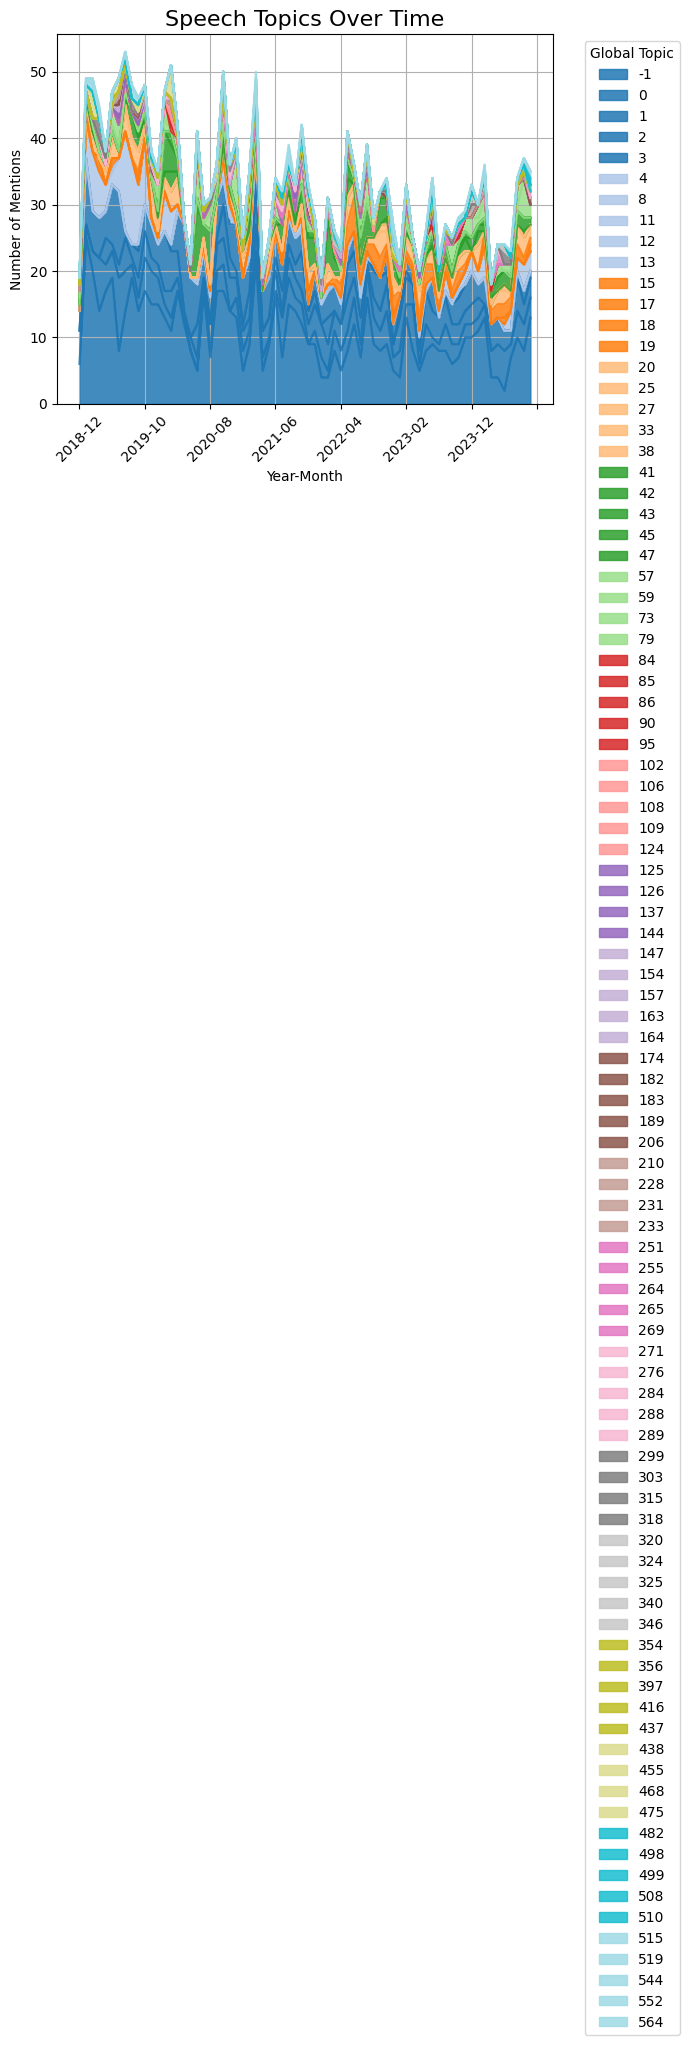

In [4]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure date is datetime
speeches_topics['date'] = pd.to_datetime(speeches_topics['date'], errors='coerce')
speeches_topics['year_month'] = speeches_topics['date'].dt.to_period('M')

# Group by topic and month
speech_topic_time = speeches_topics.groupby(['year_month', 'global_topic']).size().reset_index(name='count')

# Pivot for plotting
speech_pivot = speech_topic_time.pivot(index='year_month', columns='global_topic', values='count').fillna(0)
speech_pivot.index = speech_pivot.index.astype(str)  # for plotting

# Plot
plt.figure(figsize=(16, 7))
speech_pivot.plot(kind='area', stacked=True, colormap='tab20', alpha=0.85)
plt.title('Speech Topics Over Time', fontsize=16)
plt.xlabel('Year-Month')
plt.ylabel('Number of Mentions')
plt.xticks(rotation=45)
plt.legend(title='Global Topic', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


<ipython-input-5-8430e1c989b0>:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


<Figure size 1600x700 with 0 Axes>

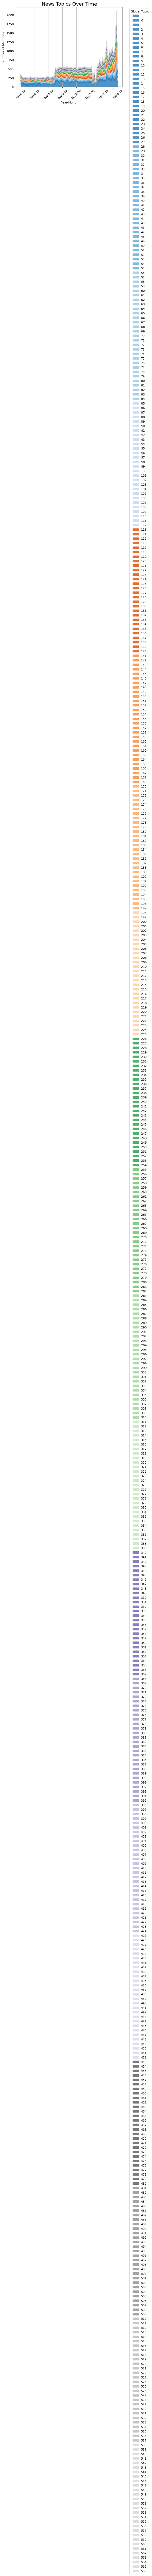

In [5]:
# Ensure date is datetime
news_topics['Date'] = pd.to_datetime(news_topics['Date'], errors='coerce')
news_topics['year_month'] = news_topics['Date'].dt.to_period('M')

# Group by topic and month
news_topic_time = news_topics.groupby(['year_month', 'global_topic']).size().reset_index(name='count')

# Pivot for plotting
news_pivot = news_topic_time.pivot(index='year_month', columns='global_topic', values='count').fillna(0)
news_pivot.index = news_pivot.index.astype(str)  # for plotting

# Plot
plt.figure(figsize=(16, 7))
news_pivot.plot(kind='area', stacked=True, colormap='tab20c', alpha=0.85)
plt.title('News Topics Over Time', fontsize=16)
plt.xlabel('Year-Month')
plt.ylabel('Number of Mentions')
plt.xticks(rotation=45)
plt.legend(title='Global Topic', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [6]:
#exploring -1 

# Count -1 topics
n_speeches_outliers = (speeches_topics['global_topic'] == -1).sum()
n_news_outliers = (news_topics['global_topic'] == -1).sum()

print(f"Outlier (topic -1) count in speeches: {n_speeches_outliers}")
print(f"Outlier (topic -1) count in news: {n_news_outliers}")



Outlier (topic -1) count in speeches: 749
Outlier (topic -1) count in news: 7823


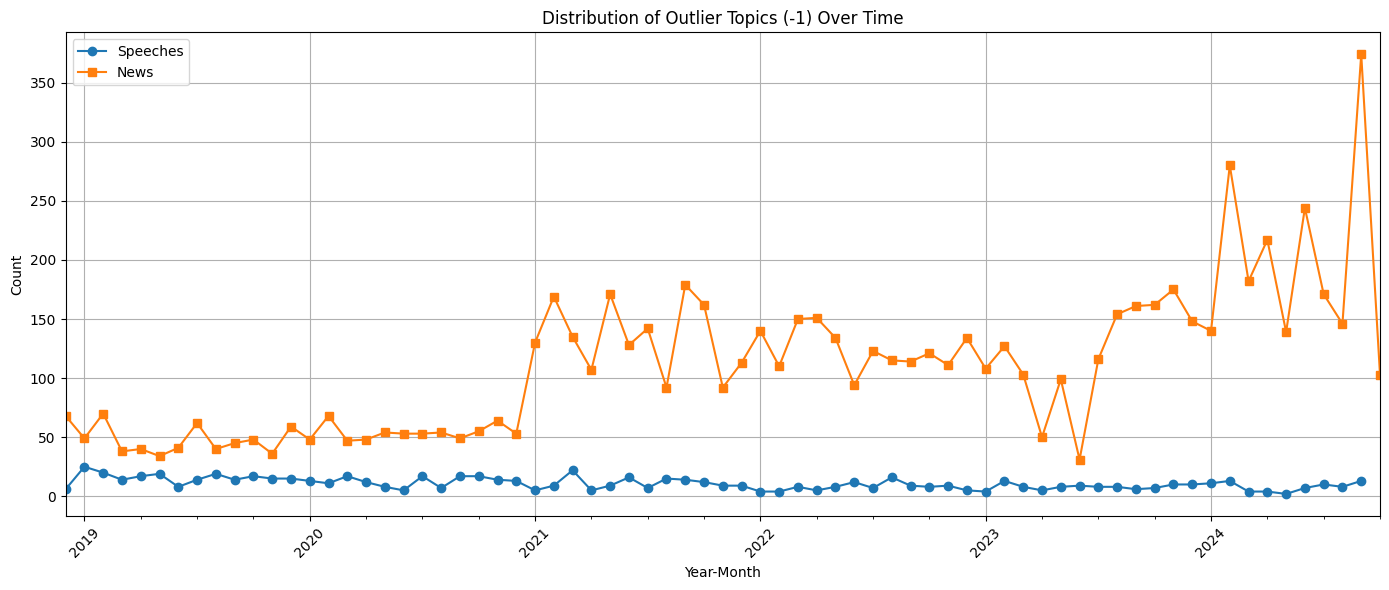

In [7]:
# Speech outliers over time
speeches_topics['date'] = pd.to_datetime(speeches_topics['date'], errors='coerce')
speeches_topics['year_month'] = speeches_topics['date'].dt.to_period('M')
speech_outlier_trend = speeches_topics[speeches_topics['global_topic'] == -1].groupby('year_month').size()

# News outliers over time
news_topics['Date'] = pd.to_datetime(news_topics['Date'], errors='coerce')
news_topics['year_month'] = news_topics['Date'].dt.to_period('M')
news_outlier_trend = news_topics[news_topics['global_topic'] == -1].groupby('year_month').size()

# Plot
plt.figure(figsize=(14, 6))
speech_outlier_trend.plot(label='Speeches', marker='o')
news_outlier_trend.plot(label='News', marker='s')
plt.title('Distribution of Outlier Topics (-1) Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [8]:
# Show a few outlier speech texts
#print("\nRandom Speech Outliers:")
#print(speeches_topics[speeches_topics['global_topic'] == -1]['clean_content'].sample(3, random_state=1).tolist())

# Show a few outlier news texts
#print("\nRandom News Outliers:")
#print(news_topics[news_topics['global_topic'] == -1]['clean_content'].sample(3, random_state=2).tolist())


In [8]:
!pip install umap-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 2.6 MB/s eta 0:00:00


In [9]:
!pip install hdbscan



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 50.9 MB/s eta 0:00:0000:0100:01


In [5]:
import joblib
import gzip

# Path to the global_topic_model.pkl file
global_topic_model_path = '/kaggle/input/topic-models/global_topic_model.pkl'

# Load the model from the file
with open(global_topic_model_path, 'rb') as f:
    global_topic_model = joblib.load(f)

# Check the components of the model (umap_model, hdbscan_model, vectorizer_model)
umap_model = global_topic_model['umap_model']
hdbscan_model = global_topic_model['hdbscan_model']
vectorizer_model = global_topic_model['vectorizer_model']

# Print the loaded models to check
print(umap_model)
print(hdbscan_model)
print(vectorizer_model)


UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.05, n_components=5, n_jobs=1, n_neighbors=8, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})
HDBSCAN(min_cluster_size=25, prediction_data=True)
CountVectorizer(ngram_range=(1, 2),
                stop_words=['estuviste', 'cómo', 'y', 'estamos', 'hubierais',
                            'siete', 'segun', 'queremos', 'seas', 'tampoco',
                            'atras', 'estados', 'nueve', 'cuantas', 'siempre',
                            'ti', 'él', 'primera', 'estabas', 'tendrán',
                            'ningunas', 'fin', 'dado', 'quiere', 'tenido',
                            'mios', 'he', 'gente', 'estuviera', 'fui', ...])


In [6]:
import numpy as np
from sklearn.cluster import KMeans

# Define a helper function to get embeddings using the loaded vectorizer model.
def get_embeddings(texts):
    # Convert texts to array embeddings using the vectorizer model.
    # (Adjust this function if you have a different embedding procedure.)
    return vectorizer_model.transform(texts).toarray()

# Define a function to compute the average embedding for each topic (excluding outliers).
def compute_topic_embeddings(df, text_column, topic_column):
    topic_embeddings = {}
    # Get unique topics, excluding the outlier (-1)
    topics = [t for t in df[topic_column].unique() if t != -1]
    for t in topics:
        # Get the texts corresponding to topic t
        docs = df[df[topic_column] == t][text_column].tolist()
        if len(docs) == 0:
            continue
        # Compute embeddings and then take the average along the document axis.
        emb = get_embeddings(docs)
        topic_embeddings[t] = np.mean(emb, axis=0)
    return topic_embeddings

In [13]:
# Compute the average embedding for each topic in speeches_topics
speeches_topic_embeddings = compute_topic_embeddings(speeches_topics, 
                                                     text_column='clean_content', 
                                                     topic_column='global_topic')

# Get the list of original topic IDs and stack their corresponding embeddings into an array.
speeches_topic_ids = list(speeches_topic_embeddings.keys())
speeches_embedding_array = np.stack([speeches_topic_embeddings[t] for t in speeches_topic_ids])
# Apply K-Means clustering to reduce the topics to 10 clusters.
num_clusters = 20  # You can adjust this number as needed.
kmeans_speeches = KMeans(n_clusters=num_clusters, random_state=42)
speeches_cluster_labels = kmeans_speeches.fit_predict(speeches_embedding_array)

# Create a mapping from original topic id to new reduced topic id.
speeches_mapping = {orig: new for orig, new in zip(speeches_topic_ids, speeches_cluster_labels)}

# Create the new 'reduced_topic' column in speeches_topics.
# If the original topic is -1 (the outlier), leave it as -1.
speeches_topics['reduced_topic'] = speeches_topics['global_topic'].apply(
    lambda t: speeches_mapping[t] if t != -1 else -1
)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gobierno', 'nacional', 'periodismo', 'relacionado'] not in stop_words.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


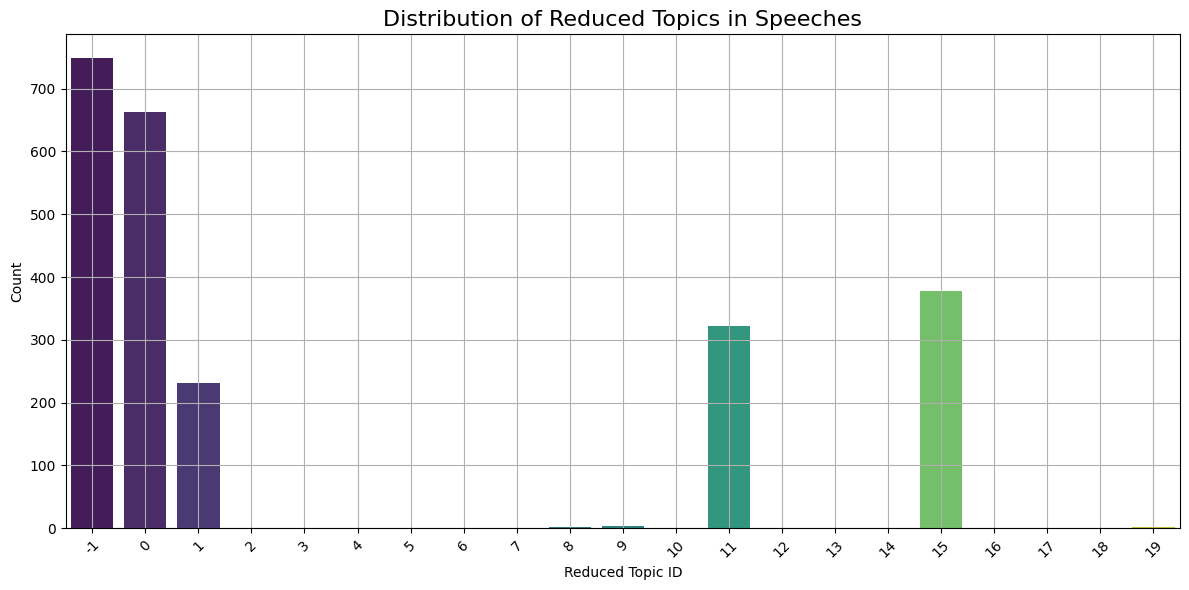

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of reduced topics in Speeches
plt.figure(figsize=(12, 6))
sns.countplot(x='reduced_topic', data=speeches_topics, palette='viridis')
plt.title('Distribution of Reduced Topics in Speeches', fontsize=16)
plt.xlabel('Reduced Topic ID')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [6]:
import numpy as np
import pandas as pd
from sklearn.cluster import MiniBatchKMeans
from collections import defaultdict

# Helper for getting a single vector per doc (or batch)
def get_sparse_embeddings(texts):
    return vectorizer_model.transform(texts)  # Sparse matrix

# Efficient mean embedding per topic — fully streaming, memory safe
def compute_topic_embeddings_streaming(df, text_column, topic_column, batch_size=100, max_docs_per_topic=None):
    topic_embeddings = {}
    topics = df[topic_column].unique()
    topics = [t for t in topics if t != -1]

    for topic in topics:
        topic_df = df[df[topic_column] == topic]
        if max_docs_per_topic:
            topic_df = topic_df.head(max_docs_per_topic)  # optional cap

        n_docs = topic_df.shape[0]
        if n_docs == 0:
            continue

        mean_vector = None
        count = 0

        # Batch the texts
        for i in range(0, n_docs, batch_size):
            batch_texts = topic_df.iloc[i:i+batch_size][text_column].tolist()
            emb = get_sparse_embeddings(batch_texts).astype(np.float32)
            batch_mean = emb.mean(axis=0)  # still sparse
            batch_mean = np.asarray(batch_mean).flatten()

            if mean_vector is None:
                mean_vector = batch_mean
            else:
                mean_vector += batch_mean
            count += 1

        # Final average
        topic_embeddings[topic] = (mean_vector / count).astype(np.float32)

    return topic_embeddings

# Compute embeddings safely
news_topic_embeddings = compute_topic_embeddings_streaming(
    news_topics,
    text_column='clean_content',
    topic_column='global_topic',
    batch_size=100,
    max_docs_per_topic=500  # optional cap per topic
)

# Build array for clustering
news_topic_ids = list(news_topic_embeddings.keys())
news_embedding_array = np.array([news_topic_embeddings[t] for t in news_topic_ids], dtype=np.float32)

# Memory-efficient clustering
num_clusters = 20
kmeans_news = MiniBatchKMeans(n_clusters=num_clusters, random_state=42, batch_size=10)
news_cluster_labels = kmeans_news.fit_predict(news_embedding_array)

# Map and assign reduced topics
news_mapping = {orig: new for orig, new in zip(news_topic_ids, news_cluster_labels)}

news_topics['reduced_topic'] = news_topics['global_topic'].apply(
    lambda t: news_mapping.get(t, -1)
)

# Output
print("Distribution of Reduced Topics in News:")
print(news_topics['reduced_topic'].value_counts())


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gobierno', 'nacional', 'periodismo', 'relacionado'] not in stop_words.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Distribution of Reduced Topics in News:
reduced_topic
 11    26091
-1      7823
 17      657
 1       508
 15      226
 8       214
 0       209
 3       183
 4       147
 5        75
 12       68
 10       66
 6        63
 7        60
 2        47
 16       32
 9        32
 13       32
 14       30
Name: count, dtype: int64


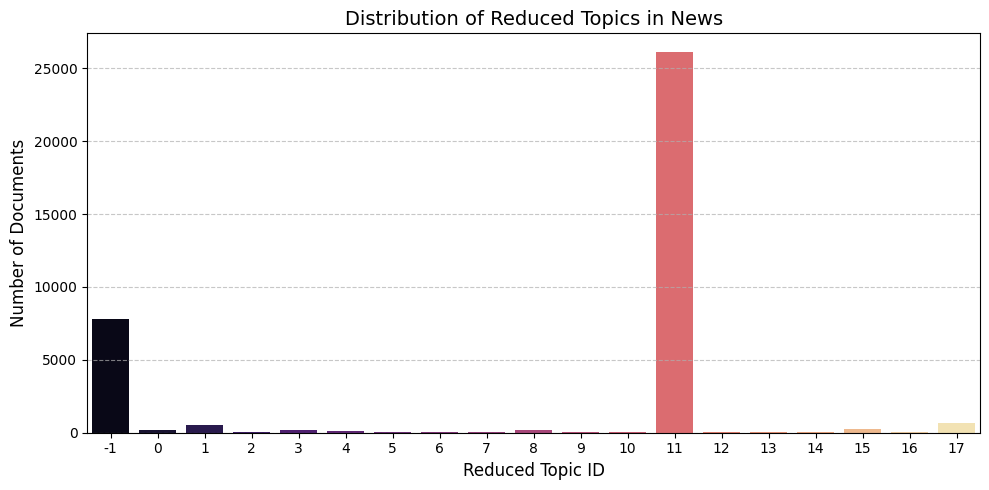

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count data for plotting (more efficient than plotting directly from large DataFrame)
topic_counts = news_topics['reduced_topic'].value_counts().sort_index()

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=topic_counts.index, y=topic_counts.values, palette='magma')

plt.title('Distribution of Reduced Topics in News', fontsize=14)
plt.xlabel('Reduced Topic ID', fontsize=12)
plt.ylabel('Number of Documents', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [9]:
# Filter news with reduced topic 11
cluster_11 = news_topics[news_topics['reduced_topic'] == 11]

# Display number of articles and a few sample entries
print(f"Number of articles in Cluster 11: {len(cluster_11)}\n")

# Show top 5 headlines or beginning of content
print(cluster_11['clean_content'].head(5).to_string(index=False))


Number of articles in Cluster 11: 26091

fuente imagen getty images campaña presidencia ...
síguenos redes sociales ciudad adnpolítico asum...
toma posesión méxico lugares prohibirá venta al...
síguenos redes sociales ciudad adnpolítico anál...
lectura 300 min nicolás maduro arribó comida ma...


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of reduced topics in Speeches

#plt.figure(figsize=(12, 6))
#sns.countplot(x='reduced_topic', data=speeches_topics, palette='viridis')
#plt.title('Distribution of Reduced Topics in Speeches', fontsize=16)
#plt.xlabel('Reduced Topic ID')
#plt.ylabel('Count')
#plt.xticks(rotation=45)
#plt.grid(True)
#plt.tight_layout()
#plt.show()

# Plot the distribution of reduced topics in News
plt.figure(figsize=(12, 6))
sns.countplot(x='reduced_topic', data=news_topics, palette='magma')
plt.title('Distribution of Reduced Topics in News', fontsize=16)
plt.xlabel('Reduced Topic ID')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


## Global topics 2 

In [10]:
!pip install umap-learn > /dev/null 2>&1
!pip install hdbscan > /dev/null 2>&1

In [11]:
import os

# See what's inside that folder
print(os.listdir("/kaggle/input/topic-models/global_topic_model2.pkl"))


['global_topic_model.pkl']


In [12]:
import pandas as pd
import pickle
import joblib
import gzip

topics_path =  "/kaggle/input/topic-models"

speeches = pd.read_csv(f"{topics_path}/speeches_with_global_topics2.csv")
news = pd.read_csv(f"{topics_path}/news_with_global_topics2.csv")
#correct path
correct_path = "/kaggle/input/topic-models/global_topic_model2.pkl/global_topic_model.pkl"

with open(correct_path, "rb") as f:
    global_topic_model = joblib.load(f)

# Now unpack the components
umap_model = global_topic_model['umap_model']
hdbscan_model = global_topic_model['hdbscan_model']
vectorizer_model = global_topic_model['vectorizer_model']



In [4]:
print(speeches.columns)
print(news.columns)

Index(['Unnamed: 0', 'X', 'speech_id', 'title', 'urls', 'content', 'date',
       'year_month', 'clean_content', 'global_topic'],
      dtype='object')
Index(['Index', 'Link', 'Domain', 'Title', 'Date', 'Content', 'month_abbr',
       'processed_content', 'year_month', 'clean_content', 'global_topic'],
      dtype='object')


In [6]:
# Check the keys in the global_topic_model dictionary
print(global_topic_model.keys())


dict_keys(['umap_model', 'hdbscan_model', 'vectorizer_model'])


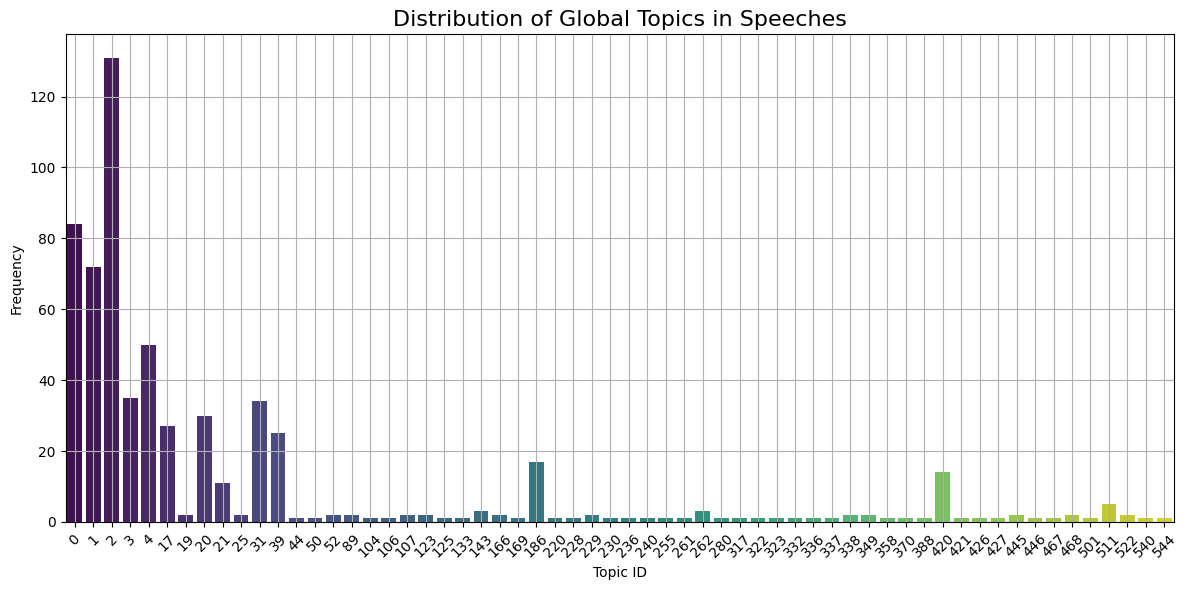

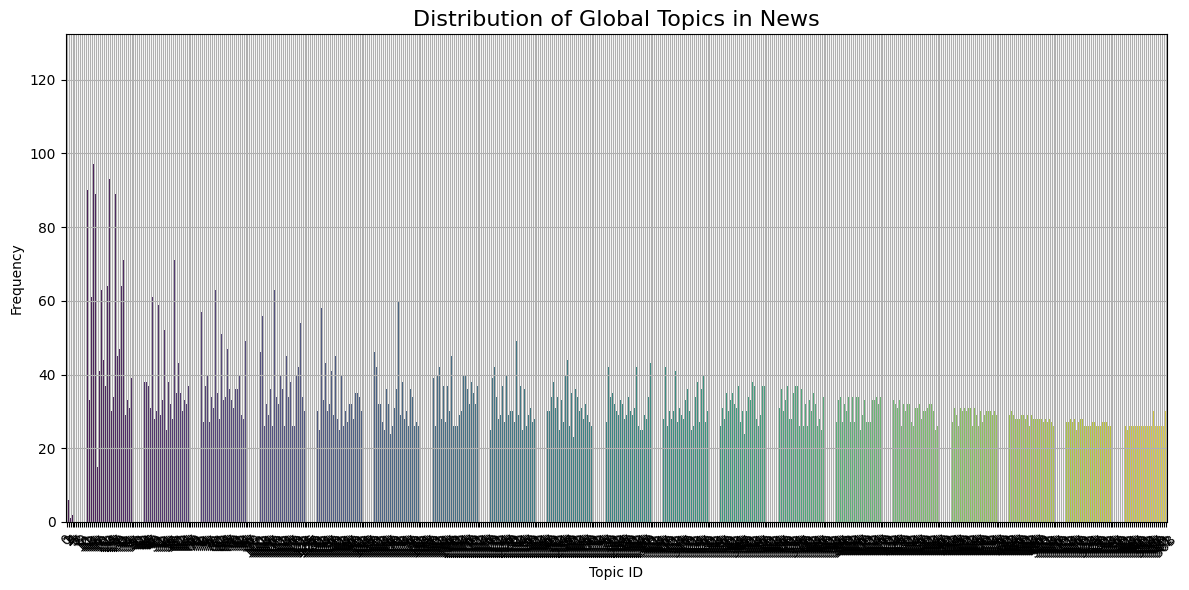

In [13]:
import ast
import matplotlib.pyplot as plt
import seaborn as sns

def plot_topic_distribution(df, source_name, topic_col='global_topic'):
    # Convert the string list into actual lists
    df['parsed_topics'] = df[topic_col].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else [])

    # Flatten all topics into one list
    all_topics = [t for sublist in df['parsed_topics'] for t in sublist]

    # Count frequencies
    topic_counts = pd.Series(all_topics).value_counts().sort_index()

    # Plot
    plt.figure(figsize=(12, 6))
    sns.barplot(x=topic_counts.index, y=topic_counts.values, palette='viridis')
    plt.title(f"Distribution of Global Topics in {source_name}", fontsize=16)
    plt.xlabel("Topic ID")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
# Run for speeches
plot_topic_distribution(speeches, "Speeches")

# Run for news
plot_topic_distribution(news, "News")


In [14]:
import ast

# Helper: parse stringified lists into actual lists
def parse_topics(df, topic_col='global_topic'):
    return df[topic_col].dropna().apply(ast.literal_eval)

# Parse topics for both datasets
news_topics = parse_topics(news)
speeches_topics = parse_topics(speeches)

# Get sets of unique topic IDs
unique_news_topics = set(t for sublist in news_topics for t in sublist)
unique_speeches_topics = set(t for sublist in speeches_topics for t in sublist)

# Compute intersection and differences
common_topics = unique_news_topics & unique_speeches_topics
only_in_news = unique_news_topics - unique_speeches_topics
only_in_speeches = unique_speeches_topics - unique_news_topics

# Print results
print(f"🔁 Common topics: {sorted(common_topics)} ({len(common_topics)})")
print(f"📰 Topics only in news: {sorted(only_in_news)} ({len(only_in_news)})")
print(f"🗣️ Topics only in speeches: {sorted(only_in_speeches)} ({len(only_in_speeches)})")


🔁 Common topics: [0, 1, 2, 4, 17, 19, 21, 25, 44, 50, 52, 89, 104, 106, 107, 123, 125, 133, 143, 166, 169, 186, 220, 228, 229, 230, 236, 240, 255, 261, 262, 280, 317, 322, 323, 332, 336, 337, 338, 349, 358, 370, 388, 420, 421, 426, 427, 445, 446, 467, 468, 501, 511, 522, 540, 544] (56)
📰 Topics only in news: [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 22, 23, 24, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 45, 46, 47, 48, 49, 51, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 105, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 124, 126, 127, 128, 129, 130, 131, 132, 134, 135, 136, 137, 138, 139, 140, 141, 142, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 167, 168, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180

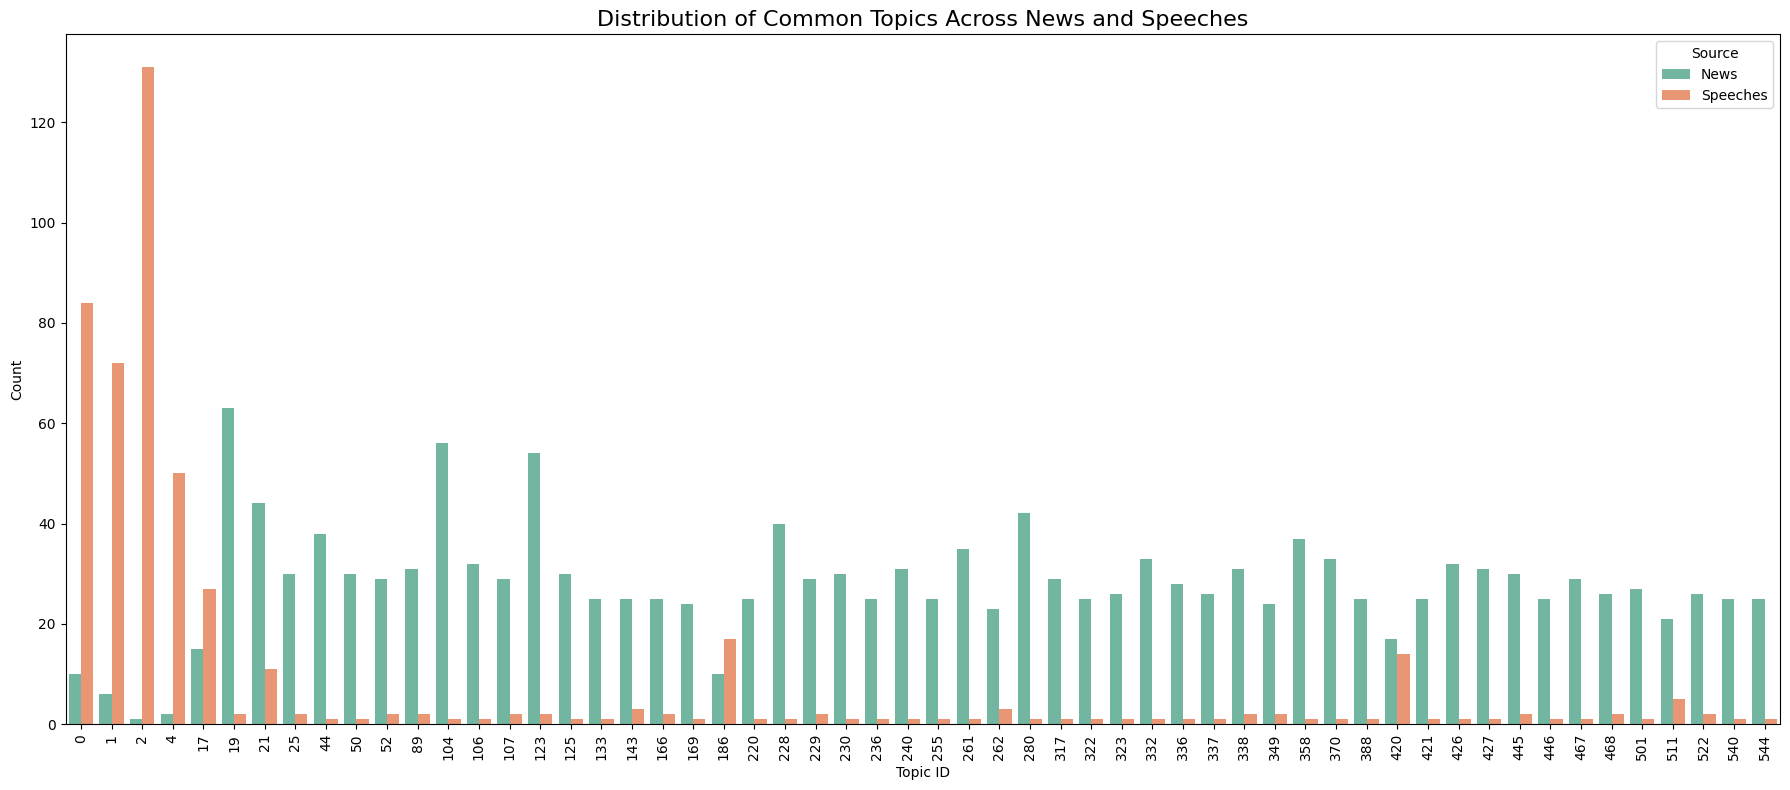

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Convert topic strings to lists
news['parsed_topics'] = news['global_topic'].dropna().apply(ast.literal_eval)
speeches['parsed_topics'] = speeches['global_topic'].dropna().apply(ast.literal_eval)

# Function to count how often common topics appear
def count_common_topics(df, common_topics):
    all_topics = [t for sublist in df['parsed_topics'] for t in sublist if t in common_topics]
    return Counter(all_topics)

# Count topic occurrences
news_common_counts = count_common_topics(news, common_topics)
speeches_common_counts = count_common_topics(speeches, common_topics)

# Create a dataframe for plotting
plot_df = pd.DataFrame({
    'topic': sorted(common_topics),
    'news_count': [news_common_counts.get(t, 0) for t in sorted(common_topics)],
    'speeches_count': [speeches_common_counts.get(t, 0) for t in sorted(common_topics)]
})

# Melt for seaborn plotting
plot_df_melted = plot_df.melt(id_vars='topic', value_vars=['news_count', 'speeches_count'],
                              var_name='source', value_name='count')

# Rename for nicer labels
plot_df_melted['source'] = plot_df_melted['source'].map({'news_count': 'News', 'speeches_count': 'Speeches'})

# Plot
plt.figure(figsize=(18, 8))
sns.barplot(x='topic', y='count', hue='source', data=plot_df_melted, palette='Set2')
plt.title("Distribution of Common Topics Across News and Speeches", fontsize=16)
plt.xlabel("Topic ID")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.legend(title="Source")
plt.tight_layout()
plt.show()


In [16]:
#from sentence_transformers import SentenceTransformer

# Load model on CPU
#embedding_model = SentenceTransformer('/kaggle/input/sentence-transformer-esp/sentence_similarity_spanish_es', device='cpu')


In [16]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Add source labels
speeches['source'] = 'speech'
news['source'] = 'news'

# Combine datasets and avoid unnecessary copy
combined_df = pd.concat([speeches[['clean_content', 'source']], news[['clean_content', 'source']]], ignore_index=True)

# Get topic labels from HDBSCAN and add them directly
combined_df['topic_label'] = hdbscan_model.labels_

# Vectorize using pre-trained TF-IDF vectorizer (assuming vectorizer_model is loaded)
texts = combined_df['clean_content'].fillna("")
tfidf_matrix = vectorizer_model.transform(texts)

# Efficient mapping of topic labels to document indices using defaultdict
topic_to_docs = defaultdict(list)
for idx, label in enumerate(combined_df['topic_label']):
    if label != -1:  # Skip outliers
        topic_to_docs[label].append(idx)

# Get feature names (vocabulary)
feature_names = vectorizer_model.get_feature_names_out()

# Extract top N words for each topic
def get_top_n_words_per_topic(tfidf_matrix, topic_to_docs, feature_names, n=10):
    topic_top_words = {}
    for topic, doc_indices in topic_to_docs.items():
        topic_tfidf = tfidf_matrix[doc_indices]
        mean_scores = np.asarray(topic_tfidf.mean(axis=0)).flatten()
        top_indices = mean_scores.argsort()[::-1][:n]
        topic_top_words[topic] = [feature_names[i] for i in top_indices]
    return topic_top_words

# Run to get top words
topic_top_words = get_top_n_words_per_topic(tfidf_matrix, topic_to_docs, feature_names, n=10)
for topic, words in list(topic_top_words.items())[:5]:
    print(f"🧠 Topic {topic}: {', '.join(words)}")

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gobierno', 'nacional', 'periodismo', 'relacionado'] not in stop_words.
  warnings.warn(


🧠 Topic 553: salud, gobierno, millones, personas, gracias, médicos, nacional, hospitales, tiempo, tema
🧠 Topic 224: centavos, gobierno, precio, tren, millones, nacional, semana, gracias, litro, tema
🧠 Topic 557: gobierno, transformación, pueblos, millones, tiempo, independencia, revolución, justicia, corrupción, historia
🧠 Topic 562: jóvenes, programa, gobierno, millones, apoyo, bienestar, salud, presupuesto, seguir, mayores
🧠 Topic 560: nacional, seguridad, gobierno, millones, guardia, baja, guardia nacional, secretaría, gracias, tema


SVD Dimensionality Reduction: 100%|██████████| 38926/38926 [01:06<00:00, 583.60it/s]
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
UMAP Transformation: 100%|██████████| 78/78 [00:39<00:00,  1.95it/s]
<ipython-input-17-f69374de37a4>:59: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


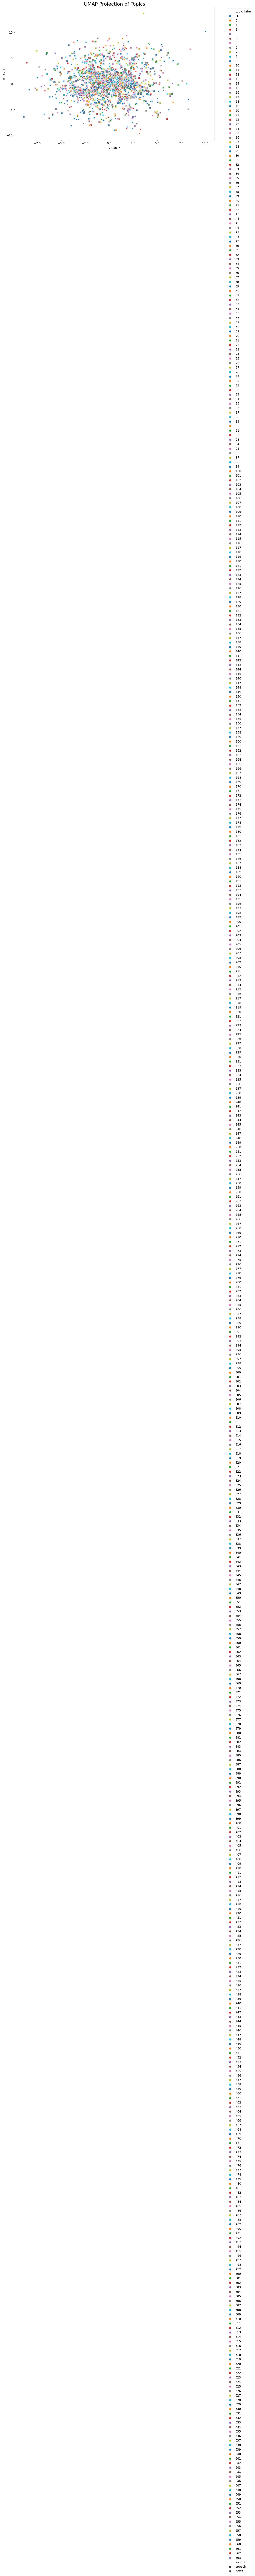

In [17]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
import umap
import numpy as np

# Assuming tfidf_matrix is already defined and UMAP model is pre-loaded
umap_model = umap.UMAP(n_neighbors=15, n_components=20, random_state=42)  # Example UMAP model

# Dimensionality reduction (SVD -> UMAP) for visualization
svd = TruncatedSVD(n_components=20)

# Track SVD progress using tqdm
with tqdm(total=tfidf_matrix.shape[0], desc="SVD Dimensionality Reduction") as pbar:
    tfidf_reduced = svd.fit_transform(tfidf_matrix)
    pbar.update(tfidf_matrix.shape[0])  # This might not show much since fit_transform happens all at once.

# Fit UMAP model on the reduced TF-IDF matrix (ensure UMAP model is trained first)
umap_model.fit(tfidf_reduced)  # Fit the model here

# Split tfidf_reduced into chunks for UMAP transformation progress
chunk_size = 500  # Adjust depending on memory and size of data
n_chunks = (tfidf_reduced.shape[0] // chunk_size) + 1

umap_embeddings = []
with tqdm(total=n_chunks, desc="UMAP Transformation") as pbar:
    for i in range(n_chunks):
        # Process each chunk
        start_idx = i * chunk_size
        end_idx = min((i + 1) * chunk_size, tfidf_reduced.shape[0])
        chunk = tfidf_reduced[start_idx:end_idx]
        
        # Transform chunk with UMAP
        umap_embeddings.append(umap_model.transform(chunk))
        
        # Update tqdm progress
        pbar.update(1)

# Combine the results
umap_embeddings = np.concatenate(umap_embeddings, axis=0)

# Assuming `combined_df` is the dataframe where UMAP coordinates will be added
combined_df['umap_x'] = umap_embeddings[:, 0]
combined_df['umap_y'] = umap_embeddings[:, 1]

# Plot UMAP results
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=combined_df,
    x='umap_x', y='umap_y',
    hue='topic_label',
    style='source',
    palette='tab10',
    alpha=0.6
)
plt.title("UMAP Projection of Topics", fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### Topic expansion

In [18]:
import os
import numpy as np
from tqdm import tqdm
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity
from concurrent.futures import ThreadPoolExecutor, as_completed
import torch
from sentence_transformers import SentenceTransformer

# ---------------------------
# Setup: Reset index and convert text Series to a list
combined_df = combined_df.reset_index(drop=True)
combined_texts = combined_df['clean_content'].fillna("").tolist()  # important: convert to list

# ---------------------------
# Load the embedding model on GPU and set it to eval mode
embedding_model = SentenceTransformer('/kaggle/input/sentence-transformer-esp/sentence_similarity_spanish_es', device='cuda')
embedding_model.eval()  # disable gradients

# ---------------------------
# Function: Compute embeddings for a batch of texts (GPU)
def get_batch_embeddings(batch_texts, model, batch_indices=None):
    embeddings = model.encode(batch_texts, convert_to_tensor=True).cpu().detach().numpy()
    return embeddings, batch_indices

# Function: Save embeddings (for checkpointing)
def save_embeddings(embeddings, save_path='embeddings.npy'):
    if not os.path.exists(save_path):
        np.save(save_path, embeddings)
    else:
        existing_embeddings = np.load(save_path)
        combined_embs = np.concatenate([existing_embeddings, embeddings], axis=0)
        np.save(save_path, combined_embs)

# Function: Load embeddings from disk if available
def load_embeddings(save_path='embeddings.npy'):
    return np.load(save_path) if os.path.exists(save_path) else None

In [19]:


# ---------------------------
# Generate document embeddings in parallel (GPU tasks use one worker)
def get_average_embeddings_parallel(texts, model, batch_size=1000, num_workers=1, save_path='embeddings.npy'):
    # Try to load saved embeddings first
    embeddings_loaded = load_embeddings(save_path)
    if embeddings_loaded is not None:
        print(f"Loaded embeddings from {save_path}")
        return embeddings_loaded

    all_embeddings = []
    num_texts = len(texts)
    # Use ThreadPoolExecutor with one worker to serialize GPU calls
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = []
        with tqdm(total=(num_texts // batch_size) + 1, desc="Generating embeddings", unit="batch") as pbar:
            for start_idx in range(0, num_texts, batch_size):
                batch_texts = texts[start_idx:start_idx + batch_size]
                batch_indices = list(range(start_idx, start_idx + len(batch_texts)))
                futures.append(executor.submit(get_batch_embeddings, batch_texts, model, batch_indices))
            for future in as_completed(futures):
                batch_embeddings, batch_indices = future.result()
                all_embeddings.append(batch_embeddings)
                save_embeddings(batch_embeddings, save_path)  # checkpoint save
                pbar.update(1)
    return np.concatenate(all_embeddings, axis=0)

# Generate or load document embeddings (using combined_texts)
combined_embeddings = get_average_embeddings_parallel(combined_texts, embedding_model, num_workers=1, save_path='embeddings.npy')

# ---------------------------
# Compute topic embeddings using document embeddings and topic-to-doc mapping
def compute_topic_embedding(topic, doc_indices, embeddings):
    if topic != -1:
        topic_embs = embeddings[doc_indices]
        topic_mean_embedding = np.mean(topic_embs, axis=0)
        return topic, topic_mean_embedding
    return None

topic_embeddings_dict = {}
with ThreadPoolExecutor(max_workers=2) as executor:
    futures = []
    with tqdm(total=len(topic_to_docs), desc="Computing topic embeddings", unit="topic") as pbar:
        for topic, doc_indices in topic_to_docs.items():
            futures.append(executor.submit(compute_topic_embedding, topic, doc_indices, combined_embeddings))
        for future in as_completed(futures):
            result = future.result()
            if result:
                topic, emb = result
                topic_embeddings_dict[topic] = emb
            pbar.update(1)

topic_list = sorted(topic_embeddings_dict.keys())
topic_embeddings = [topic_embeddings_dict[t] for t in topic_list]

# Compute similarity matrix between topic embeddings
similarity_matrix = cosine_similarity(topic_embeddings)

# ---------------------------
# Merge similar topics based on similarity threshold
threshold = 0.99  # Adjust as needed

def merge_similar_topics(i, sim_row):
    similar_topics = [j for j, sim in enumerate(sim_row) if sim > threshold and i != j]
    return [i] + similar_topics

topic_groups = []
with ThreadPoolExecutor(max_workers=2) as executor:
    futures = []
    with tqdm(total=len(similarity_matrix), desc="Grouping similar topics", unit="topic") as pbar:
        for i, sim_row in enumerate(similarity_matrix):
            futures.append(executor.submit(merge_similar_topics, i, sim_row))
        for future in as_completed(futures):
            topic_groups.append(future.result())
            pbar.update(1)

def merge_topics(group):
    if len(group) > 1:
        merged_docs = []
        for topic_idx in group:
            # Use topic_list to map back the original topic
            original_topic = topic_list[topic_idx]
            merged_docs.extend(topic_to_docs[original_topic])
        new_topic_id = max(combined_df['topic_label']) + 1  # New topic ID
        return new_topic_id, merged_docs
    return None

expanded_topics = defaultdict(list)
with ThreadPoolExecutor(max_workers=2) as executor:
    futures = []
    with tqdm(total=len(topic_groups), desc="Merging topics", unit="group") as pbar:
        for group in topic_groups:
            futures.append(executor.submit(merge_topics, group))
        for future in as_completed(futures):
            result = future.result()
            if result:
                new_topic_id, merged_docs = result
                expanded_topics[new_topic_id] = merged_docs
            pbar.update(1)

# ---------------------------
# Safely assign new topic labels to merged documents
def assign_topic_labels(new_topic_id, doc_indices):
    valid_indices = [i for i in doc_indices if i < len(combined_df)]
    if len(valid_indices) < len(doc_indices):
        invalid_indices = [i for i in doc_indices if i >= len(combined_df)]
        print(f"Warning: Invalid indices for topic {new_topic_id}: {invalid_indices}")
    return new_topic_id, valid_indices

with ThreadPoolExecutor(max_workers=2) as executor:
    futures = []
    with tqdm(total=len(expanded_topics), desc="Assigning new topic labels", unit="topic") as pbar:
        for new_topic_id, doc_indices in expanded_topics.items():
            futures.append(executor.submit(assign_topic_labels, new_topic_id, doc_indices))
        for future in as_completed(futures):
            new_topic_id, valid_indices = future.result()
            if valid_indices:
                combined_df.loc[valid_indices, 'topic_label'] = new_topic_id
            pbar.update(1)


Generating embeddings:   0%|          | 0/39 [00:00<?, ?batch/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Generating embeddings:   3%|▎         | 1/39 [00:16<10:38, 16.80s/batch]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Generating embeddings:   5%|▌         | 2/39 [00:33<10:13, 16.58s/batch]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Generating embeddings:   8%|▊         | 3/39 [00:45<08:53, 14.83s/batch]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Generating embeddings:  10%|█         | 4/39 [00:55<07:23, 12.68s/batch]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Generating embeddings:  13%|█▎        | 5/39 [01:04<06:31, 11.52s/batch]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Generating embeddings:  15%|█▌        | 6/39 [01:14<06:03, 11.02s/batch]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Generating embeddings:  18%|█▊        | 7/39 [01:25<05:46, 10.83s/batch]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Generating embeddings:  21%|██        | 8/39 [01:36<05:38, 10.93s/batch]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Generating embeddings:  23%|██▎       | 9/39 [01:48<05:41, 11.40s/batch]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Generating embeddings:  26%|██▌       | 10/39 [02:01<05:40, 11.73s/batch]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Generating embeddings:  28%|██▊       | 11/39 [02:14<05:39, 12.14s/batch]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Generating embeddings:  31%|███       | 12/39 [02:27<05:35, 12.44s/batch]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Generating embeddings:  33%|███▎      | 13/39 [02:40<05:27, 12.60s/batch]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Generating embeddings:  36%|███▌      | 14/39 [02:53<05:14, 12.57s/batch]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Generating embeddings:  38%|███▊      | 15/39 [03:05<04:58, 12.43s/batch]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Generating embeddings:  41%|████      | 16/39 [03:17<04:42, 12.27s/batch]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Generating embeddings:  44%|████▎     | 17/39 [03:29<04:29, 12.27s/batch]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Generating embeddings:  46%|████▌     | 18/39 [03:41<04:18, 12.29s/batch]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Generating embeddings:  49%|████▊     | 19/39 [03:53<04:02, 12.15s/batch]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Generating embeddings:  51%|█████▏    | 20/39 [04:05<03:52, 12.22s/batch]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Generating embeddings:  54%|█████▍    | 21/39 [04:17<03:39, 12.17s/batch]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Generating embeddings:  56%|█████▋    | 22/39 [04:30<03:27, 12.22s/batch]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Generating embeddings:  59%|█████▉    | 23/39 [04:42<03:16, 12.31s/batch]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Generating embeddings:  62%|██████▏   | 24/39 [04:54<03:02, 12.19s/batch]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Generating embeddings:  64%|██████▍   | 25/39 [05:06<02:49, 12.14s/batch]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Generating embeddings:  67%|██████▋   | 26/39 [05:19<02:39, 12.26s/batch]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Generating embeddings:  69%|██████▉   | 27/39 [05:31<02:27, 12.29s/batch]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Generating embeddings:  72%|███████▏  | 28/39 [05:42<02:10, 11.91s/batch]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Generating embeddings:  74%|███████▍  | 29/39 [05:53<01:56, 11.69s/batch]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Generating embeddings:  77%|███████▋  | 30/39 [06:04<01:43, 11.50s/batch]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Generating embeddings:  79%|███████▉  | 31/39 [06:16<01:32, 11.52s/batch]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Generating embeddings:  85%|████████▍ | 33/39 [06:39<01:08, 11.49s/batch]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Generating embeddings:  87%|████████▋ | 34/39 [06:51<00:57, 11.58s/batch]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Generating embeddings:  90%|████████▉ | 35/39 [07:02<00:45, 11.35s/batch]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Generating embeddings:  92%|█████████▏| 36/39 [07:13<00:33, 11.32s/batch]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Generating embeddings:  95%|█████████▍| 37/39 [07:25<00:23, 11.51s/batch]

Batches:   0%|          | 0/29 [00:00<?, ?it/s]

Assigning new topic labels: 100%|██████████| 1/1 [00:00<00:00, 658.45topic/s]


Unique Topics after merging: 564
topic_label
-1      7707
 0       141
 1       168
 2        52
 3        60
        ... 
 560     185
 561     108
 562     188
 563     118
 564      88
Name: count, Length: 564, dtype: int64


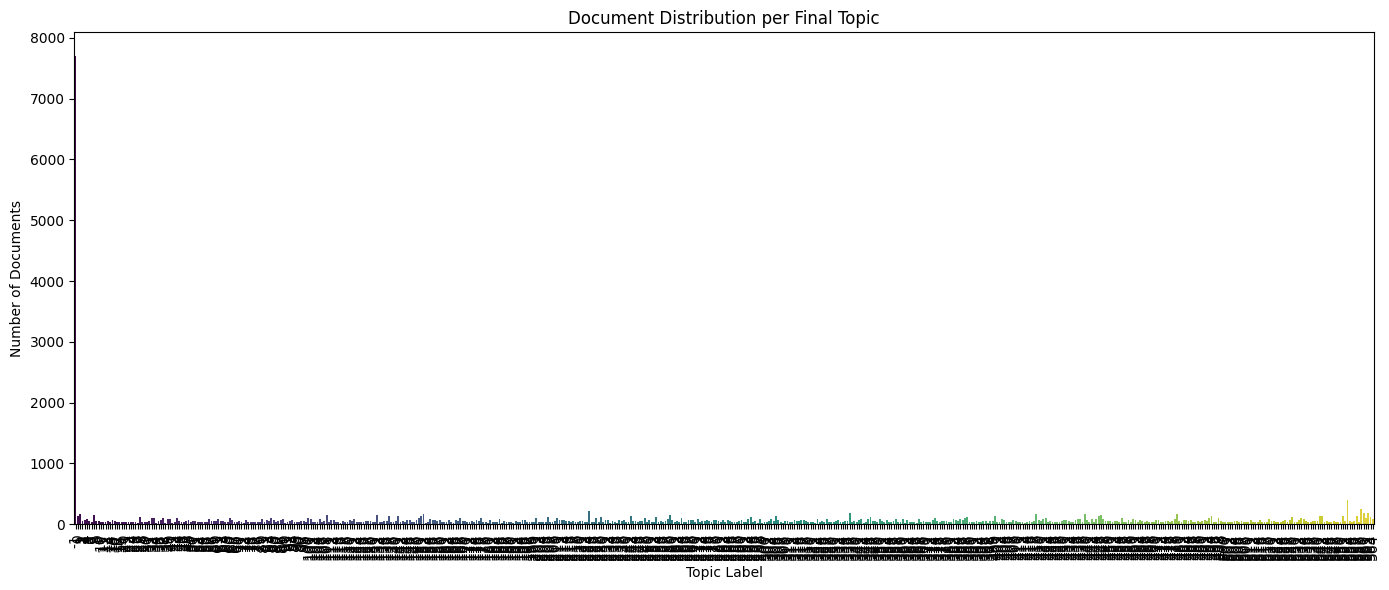

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
import umap

# ---------------------------
# 1. Print Topic Statistics
# ---------------------------
# Count the number of documents per topic in combined_df
topic_counts = combined_df['topic_label'].value_counts().sort_index()
print("Unique Topics after merging:", topic_counts.shape[0])
print(topic_counts)

# ---------------------------
# 2. Plot Bar Chart of Topic Frequencies
# ---------------------------
plt.figure(figsize=(14, 6))
sns.barplot(x=topic_counts.index.astype(str), y=topic_counts.values, palette='viridis')
plt.xlabel("Topic Label")
plt.ylabel("Number of Documents")
plt.title("Document Distribution per Final Topic")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [21]:
# For UMAP, we can use either the TF-IDF reduced embeddings from SVD or the combined_embeddings.
# Here we use the TF-IDF approach. First, apply TruncatedSVD to reduce dimensions:
svd = TruncatedSVD(n_components=100, random_state=42)
tfidf_reduced = svd.fit_transform(tfidf_matrix)

# Now use UMAP on the reduced data (if umap_model is pre-loaded, we assume it was fitted; otherwise, we fit a new one)
# If umap_model was already fitted, you can simply transform:
umap_embeddings = umap_model.transform(tfidf_reduced)
# Otherwise, uncomment and run:
# import umap
# umap_model_new = umap.UMAP(n_components=2, random_state=42)
# umap_embeddings = umap_model_new.fit_transform(tfidf_reduced)

# Add UMAP coordinates to the DataFrame
combined_df['umap_x'] = umap_embeddings[:, 0]
combined_df['umap_y'] = umap_embeddings[:, 1]

plt.figure(figsize=(12, 8))
sns.scatterplot(data=combined_df, x='umap_x', y='umap_y', hue='topic_label', style='source', palette='tab10', alpha=0.7)
plt.title("UMAP Projection of Documents by Final Topic", fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

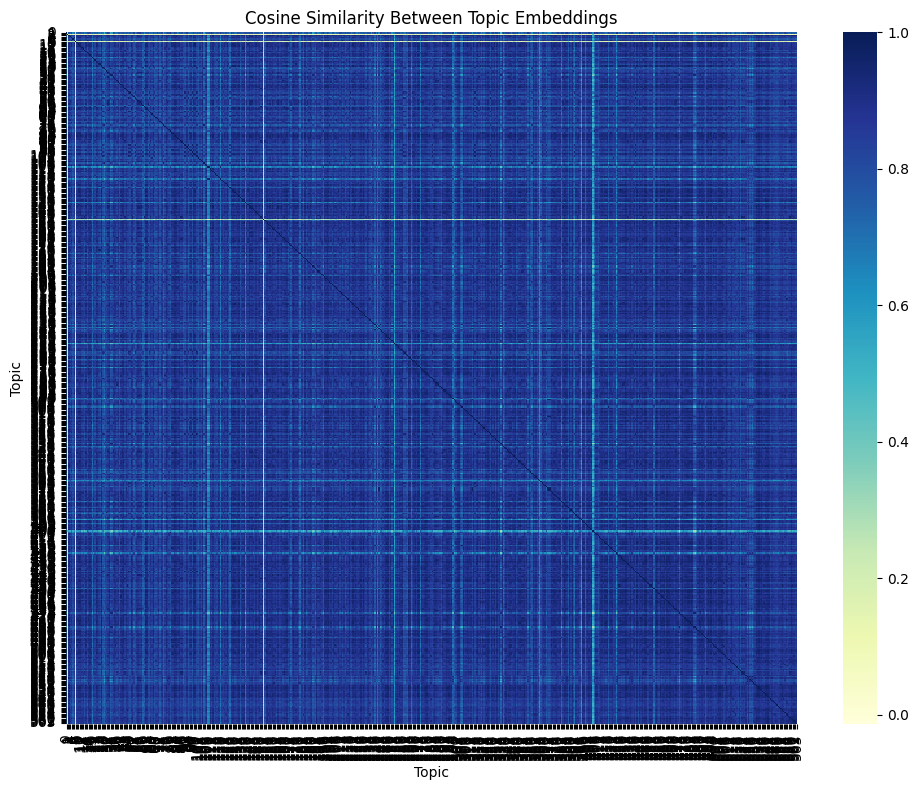

In [29]:
final_topic_embeddings = {}
for topic, doc_indices in topic_to_docs.items():
    # Only compute if this topic still exists in combined_df (if merged, these have been updated)
    valid_indices = [i for i in doc_indices if i < len(combined_df)]
    if valid_indices:
        final_topic_embeddings[topic] = np.mean(combined_embeddings[valid_indices], axis=0)

# Build a list of topic embeddings and corresponding topic IDs:
final_topics = sorted(final_topic_embeddings.keys())
final_embs = [final_topic_embeddings[t] for t in final_topics]

# Compute cosine similarity among topic embeddings
if len(final_embs) > 0:
    sim_matrix = cosine_similarity(final_embs)
    plt.figure(figsize=(10, 8))
    sns.heatmap(sim_matrix, xticklabels=final_topics, yticklabels=final_topics, cmap='YlGnBu')
    plt.title("Cosine Similarity Between Topic Embeddings")
    plt.xlabel("Topic")
    plt.ylabel("Topic")
    plt.tight_layout()
    plt.show()
else:
    print("No valid topic embeddings to show similarity.")

## AGglomerative cluster to avoid having only one major cliuster 

In [25]:
import os
import numpy as np
from tqdm import tqdm
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity
from concurrent.futures import ThreadPoolExecutor, as_completed
import torch
from sentence_transformers import SentenceTransformer

# ---------------------------
# Setup
texts = combined_df['clean_content'].fillna("").tolist()
combined_df = combined_df.reset_index(drop=True)

# Load model
model = SentenceTransformer('/kaggle/input/sentence-transformer-esp/sentence_similarity_spanish_es', device='cuda')
model.eval()


SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
)

In [26]:
# ---------------------------
# Embedding functions
def embed_batch(batch):
    return model.encode(batch, convert_to_tensor=True).cpu().numpy()

def save_checkpoint(embs, path):
    if os.path.exists(path):
        prev = np.load(path)
        embs = np.concatenate([prev, embs])
    np.save(path, embs)

def load_checkpoint(path):
    return np.load(path) if os.path.exists(path) else None
    
def embed_all_texts(texts, model, batch_size=1000, save_path='agglom_embeddings.npy'):
    cached = load_checkpoint(save_path)
    if cached is not None:
        print(f"Loaded from {save_path}")
        return cached
    
    all_embs = []
    with tqdm(total=(len(texts) + batch_size - 1) // batch_size, desc="Embedding", unit="batch") as pbar:
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i + batch_size]
            embs = embed_batch(batch)
            all_embs.append(embs)
            save_checkpoint(embs, save_path)
            pbar.update(1)
    return np.concatenate(all_embs)

doc_embeddings = embed_all_texts(texts, model)

# ---------------------------
# Topic embedding via agglomeration
def mean_topic_embedding(doc_ids):
    return np.mean(doc_embeddings[doc_ids], axis=0)

agglom_topic_embeds = {
    t: mean_topic_embedding(docs) for t, docs in topic_to_docs.items() if t != -1
}

agglom_topic_ids = sorted(agglom_topic_embeds)
agglom_vectors = [agglom_topic_embeds[t] for t in agglom_topic_ids]

# ---------------------------
# Agglomerative similarity merge
similarity = cosine_similarity(agglom_vectors)
threshold = 0.99

def find_similar_topics(idx, row):
    return [idx] + [j for j, sim in enumerate(row) if sim > threshold and j != idx]

groups = []
with ThreadPoolExecutor(max_workers=2) as pool:
    futures = [pool.submit(find_similar_topics, i, row) for i, row in enumerate(similarity)]
    for f in tqdm(as_completed(futures), total=len(futures), desc="Grouping topics"):
        groups.append(f.result())

Loaded from agglom_embeddings.npy


Grouping topics: 100%|██████████| 564/564 [00:00<00:00, 2019.91it/s]


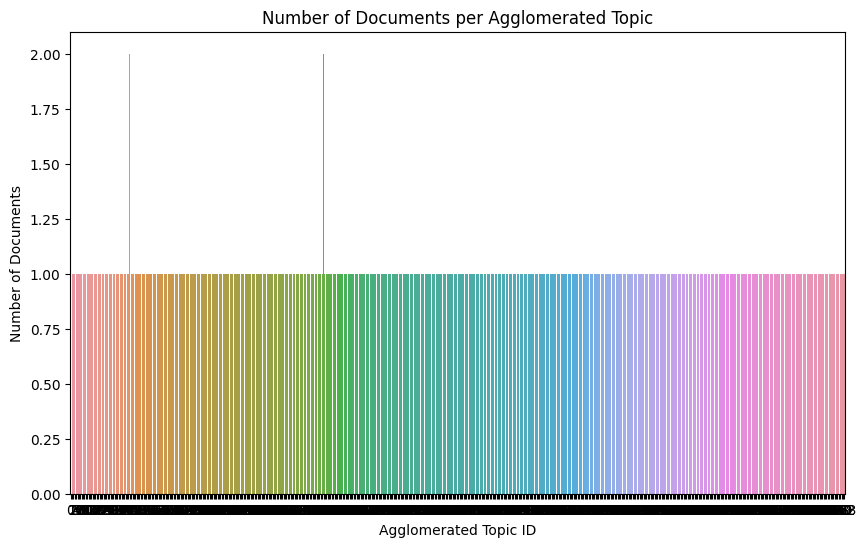

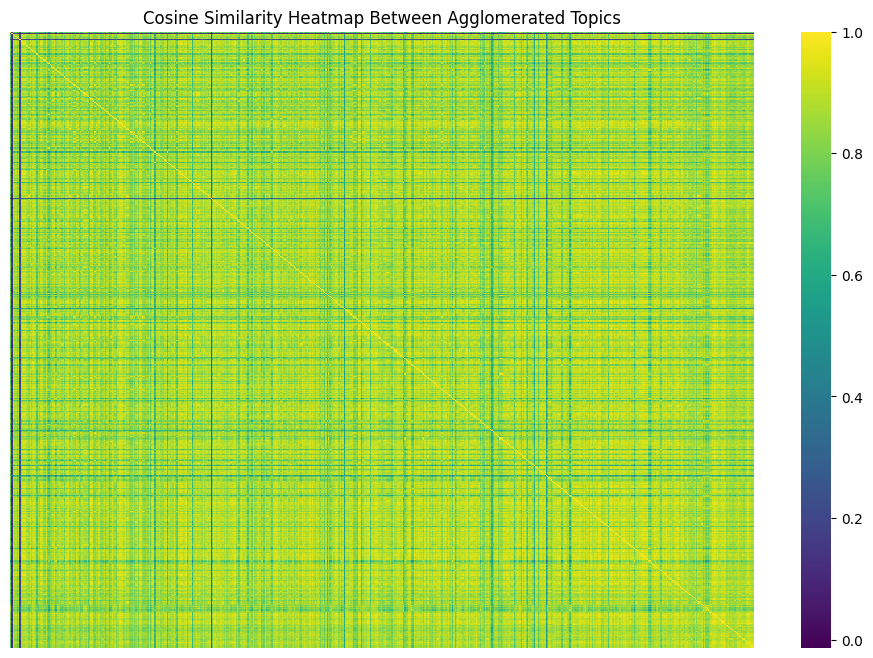

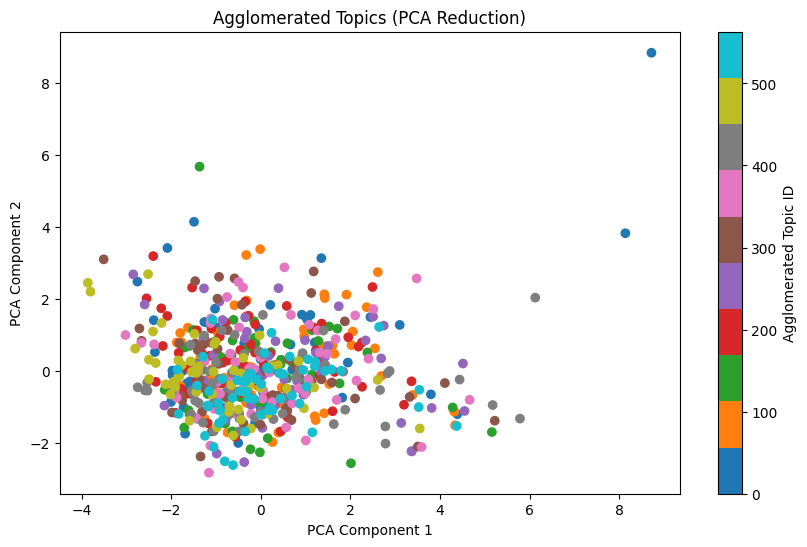

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ---------------------------
# Calculate statistics: Number of documents per agglomerated topic
topic_sizes = [len(group) for group in groups]

# Create a DataFrame for the statistics
topic_stats = pd.DataFrame({
    'agglomerated_topic_id': range(len(groups)),
    'num_documents': topic_sizes
})

# ---------------------------
# Plot the topic distribution
plt.figure(figsize=(10, 6))
sns.barplot(x='agglomerated_topic_id', y='num_documents', data=topic_stats)
plt.title('Number of Documents per Agglomerated Topic')
plt.xlabel('Agglomerated Topic ID')
plt.ylabel('Number of Documents')
plt.show()

# ---------------------------
# Cosine similarity matrix for agglomerated topics
plt.figure(figsize=(12, 8))
sns.heatmap(similarity, cmap='viridis', cbar=True, xticklabels=False, yticklabels=False)
plt.title('Cosine Similarity Heatmap Between Agglomerated Topics')
plt.show()

# ---------------------------
# Visualizing the agglomerated topics (with PCA for dimensionality reduction)
from sklearn.decomposition import PCA

# Apply PCA to reduce to 2D for visualization
pca = PCA(n_components=3)
reduced_embeddings = pca.fit_transform(agglom_vectors)

# Plot the reduced embeddings
plt.figure(figsize=(10, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=topic_stats['agglomerated_topic_id'], cmap='tab10')
plt.title('Agglomerated Topics (PCA Reduction)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Agglomerated Topic ID')
plt.show()


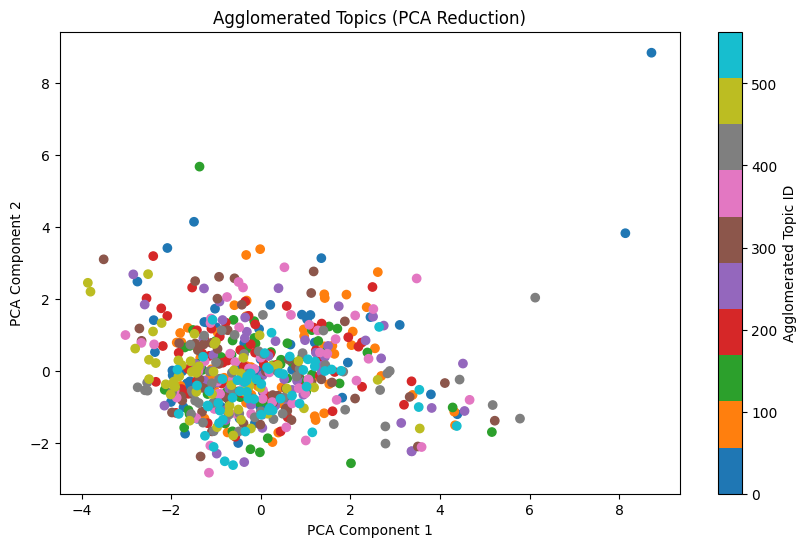

In [31]:
# Apply PCA to reduce to 2D for visualization
pca = PCA(n_components=3)
reduced_embeddings = pca.fit_transform(agglom_vectors)

# Plot the reduced embeddings
plt.figure(figsize=(10, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=topic_stats['agglomerated_topic_id'], cmap='tab10')
plt.title('Agglomerated Topics (PCA Reduction)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Agglomerated Topic ID')
plt.show()


In [29]:
# Print the number of remaining agglomerated topics
num_agglom_topics = len(groups)
print(f'Number of agglomerated topics: {num_agglom_topics}')


Number of agglomerated topics: 564


In [30]:
from sklearn.cluster import KMeans

# Number of clusters you want (10-20 topics)
n_clusters = 15

# Perform KMeans clustering on the agglomerated topic vectors
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(agglom_vectors)

# Get the cluster labels for each agglomerated topic
cluster_labels = kmeans.labels_

# Group the agglomerated topics based on the cluster labels
topic_clusters = defaultdict(list)
for topic_id, cluster_id in zip(agglom_topic_ids, cluster_labels):
    topic_clusters[cluster_id].append(topic_id)

# Check the number of clusters
print(f"Number of clusters: {len(topic_clusters)}")


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters: 15


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


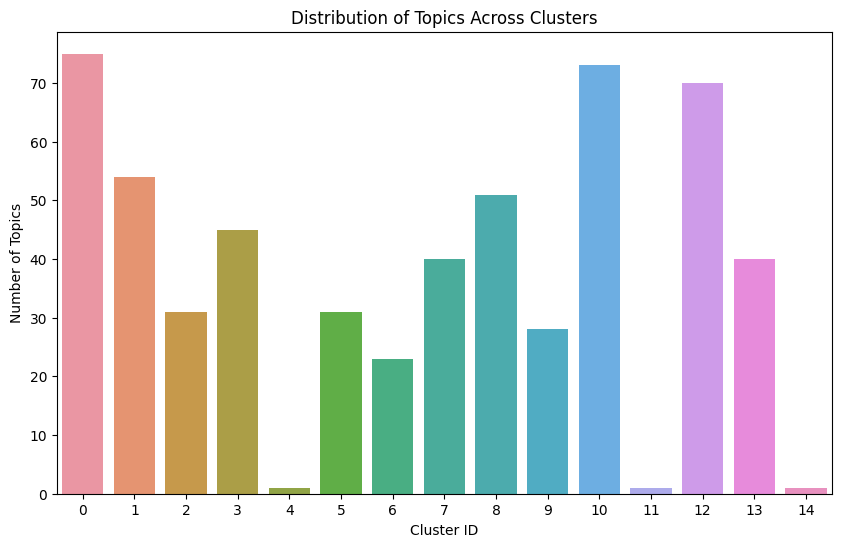

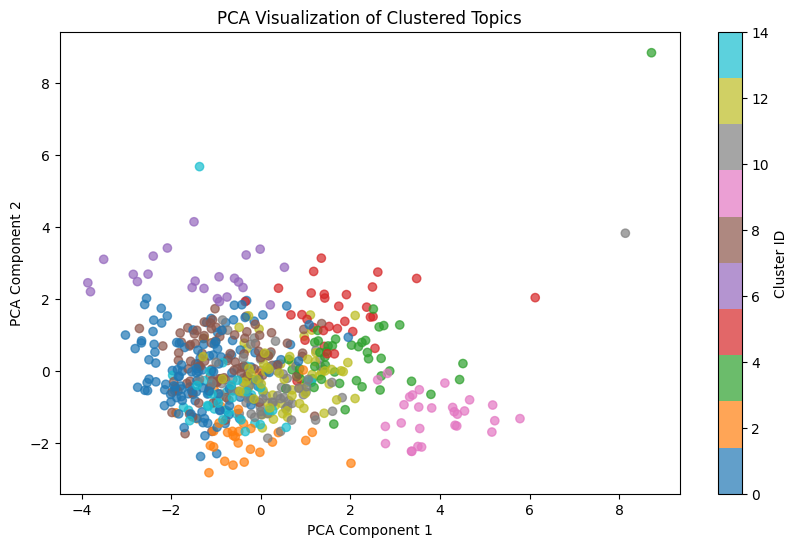

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ---------------------------
# 1. Cluster Size Distribution (Bar Plot)

# Get the number of topics in each cluster
cluster_sizes = [len(topic_clusters[cluster_id]) for cluster_id in range(len(topic_clusters))]

# Plot the distribution of topics across clusters
plt.figure(figsize=(10, 6))
sns.barplot(x=list(range(len(topic_clusters))), y=cluster_sizes)
plt.title('Distribution of Topics Across Clusters')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Topics')
plt.show()

# ---------------------------
# 2. PCA Visualization (2D) of Clustered Topics

# First, we need to reduce the agglomerated topic vectors to 2D using PCA for visualization
from sklearn.decomposition import PCA

# Reduce to 2D for visualization
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(agglom_vectors)

# Get the cluster labels from k-means
cluster_labels = kmeans.labels_

# Plot the topics based on their PCA reduction, colored by cluster label
plt.figure(figsize=(10, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=cluster_labels, cmap='tab10', alpha=0.7)
plt.title('PCA Visualization of Clustered Topics')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster ID')
plt.show()


# Calculations with cpu

In [22]:
import os
import numpy as np
from tqdm import tqdm
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity
from concurrent.futures import ThreadPoolExecutor, as_completed
import torch
from sentence_transformers import SentenceTransformer

# ---------------------------
# Setup: Ensure combined_df index is reset, and convert text column to list
combined_df = combined_df.reset_index(drop=True)
combined_texts = combined_df['clean_content'].fillna("").tolist()  # Use .tolist() here!

# Load the embedding model on CPU and set it to eval mode
embedding_model = SentenceTransformer('/kaggle/input/sentence-transformer-esp/sentence_similarity_spanish_es', device='cpu')
embedding_model.eval()

# ---------------------------
# Function: Compute embeddings for a batch of texts
def get_batch_embeddings(batch_texts, model, batch_indices=None):
    embeddings = model.encode(batch_texts, convert_to_tensor=True).cpu().detach().numpy()
    return embeddings, batch_indices

# Function: Save embeddings to disk (for checkpointing)
def save_embeddings(embeddings, save_path='embeddings.npy'):
    if not os.path.exists(save_path):
        np.save(save_path, embeddings)
    else:
        existing_embeddings = np.load(save_path)
        combined_embeddings = np.concatenate([existing_embeddings, embeddings], axis=0)
        np.save(save_path, combined_embeddings)

# Function: Load embeddings from disk if available
def load_embeddings(save_path='embeddings.npy'):
    return np.load(save_path) if os.path.exists(save_path) else None

# Function: Generate document embeddings in parallel and save each batch
def get_average_embeddings_parallel(texts, model, batch_size=1000, num_workers=2, save_path='embeddings.npy'):
    # Attempt to load previously saved embeddings:
    embeddings_loaded = load_embeddings(save_path)
    if embeddings_loaded is not None:
        print(f"Loaded embeddings from {save_path}")
        return embeddings_loaded

    all_embeddings = []
    num_texts = len(texts)
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = []
        with tqdm(total=(num_texts // batch_size) + 1, desc="Generating embeddings", unit="batch") as pbar:
            for start_idx in range(0, num_texts, batch_size):
                batch_texts = texts[start_idx:start_idx + batch_size]
                batch_indices = list(range(start_idx, start_idx + len(batch_texts)))
                futures.append(executor.submit(get_batch_embeddings, batch_texts, model, batch_indices))
            for future in as_completed(futures):
                batch_embeddings, batch_indices = future.result()
                all_embeddings.append(batch_embeddings)
                save_embeddings(batch_embeddings, save_path)  # Save each batch
                pbar.update(1)
    return np.concatenate(all_embeddings, axis=0)

# Generate or load document embeddings (using combined_texts, not Series!)
combined_embeddings = get_average_embeddings_parallel(combined_texts, embedding_model, save_path='embeddings.npy')

# ---------------------------
# Compute topic embeddings using document embeddings and topic-to-doc mapping
def compute_topic_embedding(topic, doc_indices, embeddings):
    if topic != -1:
        topic_embs = embeddings[doc_indices]
        return topic, np.mean(topic_embs, axis=0)
    return None

# topic_to_docs is assumed to have been defined earlier (mapping topic label -> list of document indices)
topic_embeddings_dict = {}
with ThreadPoolExecutor(max_workers=2) as executor:
    futures = []
    with tqdm(total=len(topic_to_docs), desc="Computing topic embeddings", unit="topic") as pbar:
        for topic, doc_indices in topic_to_docs.items():
            futures.append(executor.submit(compute_topic_embedding, topic, doc_indices, combined_embeddings))
        for future in as_completed(futures):
            result = future.result()
            if result:
                topic, emb = result
                topic_embeddings_dict[topic] = emb
            pbar.update(1)

# Create ordered list of topics and embeddings
topic_list = sorted(topic_embeddings_dict.keys())
topic_embeddings = [topic_embeddings_dict[t] for t in topic_list]

# Compute similarity matrix between topic embeddings
similarity_matrix = cosine_similarity(topic_embeddings)

# ---------------------------
# Merge similar topics based on similarity threshold
threshold = 0.5  # Adjust as needed

def merge_similar_topics(i, sim_row):
    similar_topics = [j for j, sim in enumerate(sim_row) if sim > threshold and i != j]
    return [i] + similar_topics

topic_groups = []
with ThreadPoolExecutor(max_workers=2) as executor:
    futures = []
    with tqdm(total=len(similarity_matrix), desc="Grouping similar topics", unit="topic") as pbar:
        for i, sim_row in enumerate(similarity_matrix):
            futures.append(executor.submit(merge_similar_topics, i, sim_row))
        for future in as_completed(futures):
            topic_groups.append(future.result())
            pbar.update(1)

def merge_topics(group):
    if len(group) > 1:
        merged_docs = []
        for topic_idx in group:
            original_topic = topic_list[topic_idx]
            merged_docs.extend(topic_to_docs[original_topic])
        new_topic_id = max(combined_df['topic_label']) + 1
        return new_topic_id, merged_docs
    return None

expanded_topics = defaultdict(list)
with ThreadPoolExecutor(max_workers=2) as executor:
    futures = []
    with tqdm(total=len(topic_groups), desc="Merging topics", unit="group") as pbar:
        for group in topic_groups:
            futures.append(executor.submit(merge_topics, group))
        for future in as_completed(futures):
            result = future.result()
            if result:
                new_topic_id, merged_docs = result
                expanded_topics[new_topic_id] = merged_docs
            pbar.update(1)

# ---------------------------
# Safely assign new topic labels to merged documents
def assign_topic_labels(new_topic_id, doc_indices):
    valid_indices = [i for i in doc_indices if i < len(combined_df)]
    if len(valid_indices) < len(doc_indices):
        invalid_indices = [i for i in doc_indices if i >= len(combined_df)]
        print(f"Warning: Invalid indices for topic {new_topic_id}: {invalid_indices}")
    return new_topic_id, valid_indices

with ThreadPoolExecutor(max_workers=2) as executor:
    futures = []
    with tqdm(total=len(expanded_topics), desc="Assigning new topic labels", unit="topic") as pbar:
        for new_topic_id, doc_indices in expanded_topics.items():
            futures.append(executor.submit(assign_topic_labels, new_topic_id, doc_indices))
        for future in as_completed(futures):
            new_topic_id, valid_indices = future.result()
            if valid_indices:
                combined_df.loc[valid_indices, 'topic_label'] = new_topic_id
            pbar.update(1)


Generating embeddings:   0%|          | 0/39 [00:00<?, ?batch/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Generating embeddings:   3%|▎         | 1/39 [26:25<16:43:52, 1585.06s/batch]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Generating embeddings:   5%|▌         | 2/39 [26:33<6:45:22, 657.37s/batch]  

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Generating embeddings:   8%|▊         | 3/39 [42:01<7:48:38, 781.06s/batch]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Generating embeddings:   8%|▊         | 3/39 [44:07<8:49:27, 882.43s/batch]


KeyboardInterrupt: 

In [20]:
import numpy as np
from tqdm import tqdm
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity
from concurrent.futures import ThreadPoolExecutor, as_completed
import torch
import os
from sentence_transformers import SentenceTransformer

# Load model on CPU
embedding_model = SentenceTransformer('/kaggle/input/sentence-transformer-esp/sentence_similarity_spanish_es', device='cpu')

# Disable gradients for faster inference
embedding_model.eval()

combined_df = combined_df.reset_index(drop=True)
# Function to compute embeddings for a batch of texts
def get_batch_embeddings(batch_texts, model, batch_indices=None):
    embeddings = model.encode(batch_texts, convert_to_tensor=True).cpu().detach().numpy()
    return embeddings, batch_indices

# Save embeddings in case of errors
def save_embeddings(embeddings, save_path='embeddings.npy'):
    if not os.path.exists(save_path):
        np.save(save_path, embeddings)
    else:
        existing_embeddings = np.load(save_path)
        combined_embeddings = np.concatenate([existing_embeddings, embeddings], axis=0)
        np.save(save_path, combined_embeddings)

# Parallelized embedding generation function
def get_average_embeddings_parallel(texts, model, batch_size=1000, num_workers=2, save_path='embeddings.npy'):
    embeddings = []
    num_texts = len(texts)

    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = []
        with tqdm(total=(num_texts // batch_size) + 1, desc="Generating embeddings", unit="batch") as pbar:
            for start_idx in range(0, num_texts, batch_size):
                batch_texts = texts[start_idx:start_idx + batch_size]
                batch_indices = list(range(start_idx, start_idx + len(batch_texts)))
                futures.append(executor.submit(get_batch_embeddings, batch_texts, model, batch_indices))
            
            for future in as_completed(futures):
                batch_embeddings, batch_indices = future.result()
                embeddings.append(batch_embeddings)
                save_embeddings(batch_embeddings, save_path)  # Save after each batch
                pbar.update(1)

    return np.concatenate(embeddings, axis=0)

# Assuming `combined_df['clean_content']` contains the text
combined_embeddings = get_average_embeddings_parallel(combined_df['clean_content'], embedding_model, save_path='embeddings.npy')

# Compute cosine similarity between topic embeddings
def compute_topic_embedding(topic, doc_indices, embeddings):
    if topic != -1:
        topic_embeddings = embeddings[doc_indices]
        topic_mean_embedding = np.mean(topic_embeddings, axis=0)
        return topic_mean_embedding
    return None

topic_embeddings = []
with ThreadPoolExecutor(max_workers=2) as executor:  # Reduced workers to 2
    futures = []
    with tqdm(total=len(topic_to_docs), desc="Computing topic embeddings", unit="topic") as pbar:
        for topic, doc_indices in topic_to_docs.items():
            futures.append(executor.submit(compute_topic_embedding, topic, doc_indices, combined_embeddings))
        
        for future in as_completed(futures):
            topic_embedding = future.result()
            if topic_embedding is not None:
                topic_embeddings.append(topic_embedding)
            pbar.update(1)

# Compute the similarity matrix between topic embeddings
similarity_matrix = cosine_similarity(topic_embeddings)

# Threshold to merge topics based on similarity
threshold = 0.5  # Adjust the threshold based on how aggressive you want topic merging to be
expanded_topics = defaultdict(list)
topic_groups = []

# Group similar topics based on similarity matrix in parallel
def merge_similar_topics(i, sim_row):
    similar_topics = [j for j, sim in enumerate(sim_row) if sim > threshold and i != j]
    return [i] + similar_topics

with ThreadPoolExecutor(max_workers=2) as executor:  # Reduced workers to 2
    futures = []
    with tqdm(total=len(similarity_matrix), desc="Merging similar topics", unit="topic") as pbar:
        for i, sim_row in enumerate(similarity_matrix):
            futures.append(executor.submit(merge_similar_topics, i, sim_row))
        
        for future in as_completed(futures):
            topic_groups.append(future.result())
            pbar.update(1)

# Merge similar topics into new groups
def merge_topics(group):
    if len(group) > 1:  # If there are similar topics
        merged_docs = [doc for topic in group for doc in topic_to_docs[topic]]
        new_topic_id = max(combined_df['topic_label']) + 1  # Create a new topic ID
        return new_topic_id, merged_docs
    return None

expanded_topics = defaultdict(list)
with ThreadPoolExecutor(max_workers=2) as executor:  # Reduced workers to 2
    futures = []
    with tqdm(total=len(topic_groups), desc="Merging topics", unit="group") as pbar:
        for group in topic_groups:
            futures.append(executor.submit(merge_topics, group))
        
        for future in as_completed(futures):
            result = future.result()
            if result:
                new_topic_id, merged_docs = result
                expanded_topics[new_topic_id] = merged_docs
            pbar.update(1)

# Assign new topic labels to merged documents in parallel
def assign_topic_labels(new_topic_id, doc_indices):
    return new_topic_id, doc_indices

with ThreadPoolExecutor(max_workers=2) as executor:  # Reduced workers to 2
    futures = []
    with tqdm(total=len(expanded_topics), desc="Assigning new topic labels", unit="topic") as pbar:
        for new_topic_id, doc_indices in expanded_topics.items():
            futures.append(executor.submit(assign_topic_labels, new_topic_id, doc_indices))
        
        for future in as_completed(futures):
            new_topic_id, doc_indices = future.result()
            combined_df.loc[doc_indices, 'topic_label'] = new_topic_id
            pbar.update(1)


Generating embeddings:   0%|          | 0/39 [00:02<?, ?batch/s]


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

KeyError: 163

In [17]:
import os
import numpy as np
from tqdm import tqdm
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity
from concurrent.futures import ProcessPoolExecutor, as_completed

# Function to save embeddings to a file
def save_embeddings(embeddings, filename):
    np.save(filename, embeddings)
    print(f"Embeddings saved to {filename}")

# Function to load embeddings from a file
def load_embeddings(filename):
    if os.path.exists(filename):
        embeddings = np.load(filename)
        print(f"Embeddings loaded from {filename}")
        return embeddings
    else:
        return None

# Get document embeddings using pre-trained model in parallel
def get_batch_embeddings(batch_texts, model):
    return model.encode(batch_texts, convert_to_tensor=True).cpu().detach().numpy()

def get_average_embeddings_parallel(texts, model, batch_size=10000, num_workers=8, save_path="combined_embeddings.npy"):
    embeddings = []
    num_texts = len(texts)

    # Check if embeddings file already exists
    embeddings = load_embeddings(save_path)
    if embeddings is not None:
        return embeddings

    # Using ProcessPoolExecutor for true parallelism
    with ProcessPoolExecutor(max_workers=num_workers) as executor:
        futures = []
        with tqdm(total=(num_texts // batch_size) + 1, desc="Generating embeddings", unit="batch") as pbar:
            for start_idx in range(0, num_texts, batch_size):
                batch_texts = texts[start_idx:start_idx + batch_size]
                futures.append(executor.submit(get_batch_embeddings, batch_texts, model))
            
            # Collect the results as they complete and update tqdm progress
            for future in as_completed(futures):
                embeddings.append(future.result())
                pbar.update(1)  # Update the progress bar after each future finishes

    embeddings = np.concatenate(embeddings, axis=0)
    save_embeddings(embeddings, save_path)  # Save embeddings to a file after generation
    return embeddings

# Assuming `embedding_model` is pre-loaded and `combined_df` contains the text
combined_embeddings = get_average_embeddings_parallel(combined_df['clean_content'], embedding_model)

# Compute cosine similarity between topic embeddings in parallel
def compute_topic_embedding(topic, doc_indices, embeddings):
    if topic != -1:
        topic_embeddings = embeddings[doc_indices]
        topic_mean_embedding = np.mean(topic_embeddings, axis=0)
        return topic_mean_embedding
    return None

topic_embeddings = []
with ProcessPoolExecutor(max_workers=8) as executor:
    futures = []
    with tqdm(total=len(topic_to_docs), desc="Computing topic embeddings", unit="topic") as pbar:
        for topic, doc_indices in topic_to_docs.items():
            futures.append(executor.submit(compute_topic_embedding, topic, doc_indices, combined_embeddings))
        
        for future in as_completed(futures):
            topic_embedding = future.result()
            if topic_embedding is not None:
                topic_embeddings.append(topic_embedding)
            pbar.update(1)  # Update progress bar as futures complete

# Compute the similarity matrix between topic embeddings in parallel
def compute_similarity_matrix_parallel(topic_embeddings, num_workers=8):
    similarity_matrix = np.zeros((len(topic_embeddings), len(topic_embeddings)))

    def compute_similarity(i):
        for j in range(i + 1, len(topic_embeddings)):
            similarity = cosine_similarity([topic_embeddings[i]], [topic_embeddings[j]])[0][0]
            similarity_matrix[i, j] = similarity
            similarity_matrix[j, i] = similarity

    with ProcessPoolExecutor(max_workers=num_workers) as executor:
        futures = [executor.submit(compute_similarity, i) for i in range(len(topic_embeddings))]
        for future in as_completed(futures):
            pass  # All computations are done inside compute_similarity
    return similarity_matrix

similarity_matrix = compute_similarity_matrix_parallel(topic_embeddings)

# Threshold to merge topics based on similarity
threshold = 0.5  # Adjust the threshold based on how aggressive you want topic merging to be
expanded_topics = defaultdict(list)
topic_groups = []

# Group similar topics based on similarity matrix in parallel
def merge_similar_topics(i, sim_row):
    similar_topics = [j for j, sim in enumerate(sim_row) if sim > threshold and i != j]
    return [i] + similar_topics

with ProcessPoolExecutor(max_workers=8) as executor:
    futures = []
    with tqdm(total=len(similarity_matrix), desc="Merging similar topics", unit="topic") as pbar:
        for i, sim_row in enumerate(similarity_matrix):
            futures.append(executor.submit(merge_similar_topics, i, sim_row))
        
        for future in as_completed(futures):
            topic_groups.append(future.result())
            pbar.update(1)  # Update progress bar as futures complete

# Merge similar topics into new groups
def merge_topics(group):
    if len(group) > 1:  # If there are similar topics
        merged_docs = [doc for topic in group for doc in topic_to_docs[topic]]
        new_topic_id = max(combined_df['topic_label']) + 1  # Create a new topic ID
        return new_topic_id, merged_docs
    return None

expanded_topics = defaultdict(list)
with ProcessPoolExecutor(max_workers=8) as executor:
    futures = []
    with tqdm(total=len(topic_groups), desc="Merging topics", unit="group") as pbar:
        for group in topic_groups:
            futures.append(executor.submit(merge_topics, group))
        
        for future in as_completed(futures):
            result = future.result()
            if result:
                new_topic_id, merged_docs = result
                expanded_topics[new_topic_id] = merged_docs
            pbar.update(1)  # Update progress bar as futures complete

# Assign new topic labels to merged documents in parallel
def assign_topic_labels(new_topic_id, doc_indices):
    # Filter out invalid indices
    valid_indices = [i for i in doc_indices if i < len(combined_df)]
    invalid_indices = [i for i in doc_indices if i >= len(combined_df)]
    if invalid_indices:
        print(f"Warning: Invalid indices found: {invalid_indices}")
    return new_topic_id, valid_indices

# Proceed with the parallel assignment of topic labels
with ProcessPoolExecutor(max_workers=8) as executor:
    futures = []
    with tqdm(total=len(expanded_topics), desc="Assigning new topic labels", unit="topic") as pbar:
        for new_topic_id, doc_indices in expanded_topics.items():
            futures.append(executor.submit(assign_topic_labels, new_topic_id, doc_indices))

        for future in as_completed(futures):
            new_topic_id, doc_indices = future.result()
            if doc_indices:  # Only assign if there are valid indices
                combined_df.loc[doc_indices, 'topic_label'] = new_topic_id
            pbar.update(1)  # Update progress bar as futures complete


Generating embeddings:   0%|          | 0/4 [00:09<?, ?batch/s]
Process ForkProcess-3:
Process ForkProcess-8:
Process ForkProcess-7:
Process ForkProcess-2:
Process ForkProcess-6:
Process ForkProcess-4:
Process ForkProcess-5:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/proces

KeyboardInterrupt: 

In [ ]:
## Wroking for cpu but currently takes a lot of time to run (4hrs) and still not fully working since it has errors /usr/local/lib/python3.10/dist-packages/pandas/core/indexes/range.py in get_loc(self, key)
   # 413                 return self._range.index(new_key)
   # 414             except ValueError as err:
#--> 415                 raise KeyError(key) from err
 #   416         if isinstance(key, Hashable):
  #  417             raise KeyError(key)

#KeyError: 3237

In [ ]:
from tqdm import tqdm
import numpy as np
from collections import defaultdict

# Get document embeddings using pre-trained model
def get_average_embeddings(texts, model, batch_size=10000):
    embeddings = []
    num_texts = len(texts)
    
    for start_idx in tqdm(range(0, num_texts, batch_size), desc="Generating embeddings", unit="batch"):
        # Process each batch of texts
        batch_texts = texts[start_idx:start_idx + batch_size]
        batch_embeddings = model.encode(batch_texts, convert_to_tensor=True).cpu().detach().numpy()
        embeddings.append(batch_embeddings)
        
        # Optionally update progress after each batch
    return np.concatenate(embeddings, axis=0)

# Assuming `embedding_model` is pre-loaded and `combined_df` contains the text
combined_embeddings = get_average_embeddings(combined_df['clean_content'], embedding_model)

# Compute cosine similarity between topic embeddings
topic_embeddings = []
for topic, doc_indices in tqdm(topic_to_docs.items(), desc="Computing topic embeddings", unit="topic"):
    if topic != -1:
        topic_tfidf = combined_embeddings[doc_indices]
        topic_mean_embedding = np.mean(topic_tfidf, axis=0)
        topic_embeddings.append(topic_mean_embedding)

similarity_matrix = cosine_similarity(topic_embeddings)

# Threshold to merge topics based on similarity
threshold = 0.5  # Adjust the threshold based on how aggressive you want topic merging to be
expanded_topics = defaultdict(list)
topic_groups = []

for i, sim_row in tqdm(enumerate(similarity_matrix), desc="Merging similar topics", total=len(similarity_matrix)):
    similar_topics = [j for j, sim in enumerate(sim_row) if sim > threshold and i != j]
    topic_groups.append([i] + similar_topics)

# Merge similar topics
for group in tqdm(topic_groups, desc="Merging topics", unit="group"):
    if len(group) > 1:  # If there are similar topics
        merged_docs = [doc for topic in group for doc in topic_to_docs[topic]]
        new_topic_id = max(combined_df['topic_label']) + 1  # Create a new topic ID
        expanded_topics[new_topic_id] = merged_docs

# Assign new topic labels to merged documents
for new_topic_id, doc_indices in tqdm(expanded_topics.items(), desc="Assigning new topic labels", unit="topic"):
    combined_df.loc[doc_indices, 'topic_label'] = new_topic_id


In [17]:
from tqdm import tqdm
import numpy as np
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity
from concurrent.futures import ThreadPoolExecutor, as_completed

# Get document embeddings using pre-trained model in parallel
def get_batch_embeddings(batch_texts, model):
    return model.encode(batch_texts, convert_to_tensor=True).cpu().detach().numpy()

def get_average_embeddings_parallel(texts, model, batch_size=10000, num_workers=4):
    embeddings = []
    num_texts = len(texts)

    # Creating tqdm manually for updating the progress
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = []
        with tqdm(total=(num_texts // batch_size) + 1, desc="Generating embeddings", unit="batch") as pbar:
            for start_idx in range(0, num_texts, batch_size):
                batch_texts = texts[start_idx:start_idx + batch_size]
                futures.append(executor.submit(get_batch_embeddings, batch_texts, model))
            
            # Collect the results as they complete and update tqdm progress
            for future in as_completed(futures):
                embeddings.append(future.result())
                pbar.update(1)  # Update the progress bar after each future finishes

    return np.concatenate(embeddings, axis=0)

# Assuming `embedding_model` is pre-loaded and `combined_df` contains the text
combined_embeddings = get_average_embeddings_parallel(combined_df['clean_content'], embedding_model)

# Compute cosine similarity between topic embeddings in parallel
def compute_topic_embedding(topic, doc_indices, embeddings):
    if topic != -1:
        topic_embeddings = embeddings[doc_indices]
        topic_mean_embedding = np.mean(topic_embeddings, axis=0)
        return topic_mean_embedding
    return None

topic_embeddings = []
with ThreadPoolExecutor(max_workers=4) as executor:
    futures = []
    with tqdm(total=len(topic_to_docs), desc="Computing topic embeddings", unit="topic") as pbar:
        for topic, doc_indices in topic_to_docs.items():
            futures.append(executor.submit(compute_topic_embedding, topic, doc_indices, combined_embeddings))
        
        for future in as_completed(futures):
            topic_embedding = future.result()
            if topic_embedding is not None:
                topic_embeddings.append(topic_embedding)
            pbar.update(1)  # Update progress bar as futures complete

# Compute the similarity matrix between topic embeddings
similarity_matrix = cosine_similarity(topic_embeddings)

# Threshold to merge topics based on similarity
threshold = 0.5  # Adjust the threshold based on how aggressive you want topic merging to be
expanded_topics = defaultdict(list)
topic_groups = []

# Group similar topics based on similarity matrix in parallel
def merge_similar_topics(i, sim_row):
    similar_topics = [j for j, sim in enumerate(sim_row) if sim > threshold and i != j]
    return [i] + similar_topics

with ThreadPoolExecutor(max_workers=4) as executor:
    futures = []
    with tqdm(total=len(similarity_matrix), desc="Merging similar topics", unit="topic") as pbar:
        for i, sim_row in enumerate(similarity_matrix):
            futures.append(executor.submit(merge_similar_topics, i, sim_row))
        
        for future in as_completed(futures):
            topic_groups.append(future.result())
            pbar.update(1)  # Update progress bar as futures complete

# Merge similar topics into new groups
def merge_topics(group):
    if len(group) > 1:  # If there are similar topics
        merged_docs = [doc for topic in group for doc in topic_to_docs[topic]]
        new_topic_id = max(combined_df['topic_label']) + 1  # Create a new topic ID
        return new_topic_id, merged_docs
    return None

expanded_topics = defaultdict(list)
with ThreadPoolExecutor(max_workers=4) as executor:
    futures = []
    with tqdm(total=len(topic_groups), desc="Merging topics", unit="group") as pbar:
        for group in topic_groups:
            futures.append(executor.submit(merge_topics, group))
        
        for future in as_completed(futures):
            result = future.result()
            if result:
                new_topic_id, merged_docs = result
                expanded_topics[new_topic_id] = merged_docs
            pbar.update(1)  # Update progress bar as futures complete

# Assign new topic labels to merged documents in parallel
def assign_topic_labels(new_topic_id, doc_indices):
    return new_topic_id, doc_indices

with ThreadPoolExecutor(max_workers=4) as executor:
    futures = []
    with tqdm(total=len(expanded_topics), desc="Assigning new topic labels", unit="topic") as pbar:
        for new_topic_id, doc_indices in expanded_topics.items():
            futures.append(executor.submit(assign_topic_labels, new_topic_id, doc_indices))
        
        for future in as_completed(futures):
            new_topic_id, doc_indices = future.result()
            combined_df.loc[doc_indices, 'topic_label'] = new_topic_id
            pbar.update(1)  # Update progress bar as futures complete



Generating embeddings:   0%|          | 0/4 [00:07<?, ?batch/s]


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

KeyError: 3237

In [20]:
combined_df.to_csv("combined_df_with_topics.csv", index=False)




In [22]:
%who



Counter	 PCA	 SentenceTransformer	 StandardScaler	 TfidfVectorizer	 ThreadPoolExecutor	 TruncatedSVD	 as_completed	 ast	 
chunk	 chunk_size	 combined_df	 common_topics	 correct_path	 cosine_similarity	 count_common_topics	 defaultdict	 embedding_model	 
end_idx	 f	 feature_names	 get_average_embeddings	 get_average_embeddings_parallel	 get_batch_embeddings	 get_top_n_words_per_topic	 global_topic_model	 gzip	 
hdbscan_model	 i	 idx	 joblib	 label	 n_chunks	 news	 news_common_counts	 news_topics	 
np	 only_in_news	 only_in_speeches	 os	 parse_topics	 pbar	 pd	 pickle	 plot_df	 
plot_df_melted	 plot_topic_distribution	 plt	 sns	 speeches	 speeches_common_counts	 speeches_topics	 start_idx	 svd	 
texts	 tfidf_matrix	 tfidf_reduced	 topic	 topic_to_docs	 topic_top_words	 topics_path	 tqdm	 umap	 
umap_embeddings	 umap_model	 unique_news_topics	 unique_speeches_topics	 vectorizer_model	 words	 


In [ ]:
# PCA for visualization of expanded topics
scaler = StandardScaler()
scaled_embeddings = scaler.fit_transform(topic_embeddings)

# Apply PCA for 2D visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_embeddings)

# Plot PCA results
plt.figure(figsize=(10, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=list(expanded_topics.keys()), cmap='viridis')
plt.colorbar()
plt.title("PCA of Expanded Topics")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()


## trying to use tpu

In [ ]:
pip install torch==2.1.0+cpu  # Make sure PyTorch is installed
pip install torch_xla==2.1  # Install the XLA library for TPUs


In [ ]:
import torch
import torch_xla.core.xla_model as xm
from tqdm import tqdm
import numpy as np
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity
from concurrent.futures import ThreadPoolExecutor, as_completed

# Get document embeddings using pre-trained model with TPU
def get_batch_embeddings(batch_texts, model, device):
    # Move model to TPU device
    model.to(device)
    return model.encode(batch_texts, convert_to_tensor=True).cpu().detach().numpy()

def get_average_embeddings_parallel(texts, model, batch_size=10000, num_workers=4, device='xla'):
    embeddings = []
    num_texts = len(texts)

    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        # Submit tasks for batch processing
        futures = []
        for start_idx in range(0, num_texts, batch_size):
            batch_texts = texts[start_idx:start_idx + batch_size]
            futures.append(executor.submit(get_batch_embeddings, batch_texts, model, device))
        
        # Collect the results as they complete
        for future in tqdm(as_completed(futures), desc="Generating embeddings", unit="batch"):
            embeddings.append(future.result())
    
    return np.concatenate(embeddings, axis=0)

# Assuming `embedding_model` is pre-loaded and `combined_df` contains the text
device = xm.xla_device()  # Set the device to TPU
combined_embeddings = get_average_embeddings_parallel(combined_df['clean_content'], embedding_model, device=device)

# Compute cosine similarity between topic embeddings in parallel
def compute_topic_embedding(topic, doc_indices, embeddings):
    if topic != -1:
        topic_embeddings = embeddings[doc_indices]
        topic_mean_embedding = np.mean(topic_embeddings, axis=0)
        return topic_mean_embedding
    return None

topic_embeddings = []
with ThreadPoolExecutor(max_workers=4) as executor:
    futures = []
    for topic, doc_indices in topic_to_docs.items():
        futures.append(executor.submit(compute_topic_embedding, topic, doc_indices, combined_embeddings))
    
    for future in tqdm(as_completed(futures), desc="Computing topic embeddings", unit="topic"):
        topic_embedding = future.result()
        if topic_embedding is not None:
            topic_embeddings.append(topic_embedding)

# Compute the similarity matrix between topic embeddings
similarity_matrix = cosine_similarity(topic_embeddings)

# Threshold to merge topics based on similarity
threshold = 0.5  # Adjust the threshold based on how aggressive you want topic merging to be
expanded_topics = defaultdict(list)
topic_groups = []

# Group similar topics based on similarity matrix in parallel
def merge_similar_topics(i, sim_row):
    similar_topics = [j for j, sim in enumerate(sim_row) if sim > threshold and i != j]
    return [i] + similar_topics

with ThreadPoolExecutor(max_workers=4) as executor:
    futures = []
    for i, sim_row in enumerate(similarity_matrix):
        futures.append(executor.submit(merge_similar_topics, i, sim_row))
    
    for future in tqdm(as_completed(futures), desc="Merging similar topics", unit="topic"):
        topic_groups.append(future.result())

# Merge similar topics into new groups
def merge_topics(group):
    if len(group) > 1:  # If there are similar topics
        merged_docs = [doc for topic in group for doc in topic_to_docs[topic]]
        new_topic_id = max(combined_df['topic_label']) + 1  # Create a new topic ID
        return new_topic_id, merged_docs
    return None

expanded_topics = defaultdict(list)
with ThreadPoolExecutor(max_workers=4) as executor:
    futures = []
    for group in topic_groups:
        futures.append(executor.submit(merge_topics, group))
    
    for future in tqdm(as_completed(futures), desc="Merging topics", unit="group"):
        result = future.result()
        if result:
            new_topic_id, merged_docs = result
            expanded_topics[new_topic_id] = merged_docs

# Assign new topic labels to merged documents in parallel
def assign_topic_labels(new_topic_id, doc_indices):
    return new_topic_id, doc_indices

with ThreadPoolExecutor(max_workers=4) as executor:
    futures = []
    for new_topic_id, doc_indices in expanded_topics.items():
        futures.append(executor.submit(assign_topic_labels, new_topic_id, doc_indices))
    
    for future in tqdm(as_completed(futures), desc="Assigning new topic labels", unit="topic"):
        new_topic_id, doc_indices = future.result()
        combined_df.loc[doc_indices, 'topic_label'] = new_topic_id


In [ ]:
#code crashes the kernel
# Convert the sparse TF-IDF matrix to a dense format
tfidf_dense = tfidf_matrix.toarray()

# Now, use UMAP to transform it
umap_embeddings = umap_model.transform(tfidf_dense)

# Add 2D coords to the dataframe
combined_df['umap_x'] = umap_embeddings[:, 0]
combined_df['umap_y'] = umap_embeddings[:, 1]

# Plot
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=combined_df,
    x='umap_x', y='umap_y',
    hue='topic_label',
    style='source',
    palette='tab10',
    alpha=0.6
)
plt.title("UMAP Projection of Topics", fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Convert the sparse TF-IDF matrix to a dense format
tfidf_dense = tfidf_matrix.toarray()

# Now, use UMAP to transform it
umap_embeddings = umap_model.transform(tfidf_dense)

# Add 2D coords to the dataframe
combined_df['umap_x'] = umap_embeddings[:, 0]
combined_df['umap_y'] = umap_embeddings[:, 1]

# Plot
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=combined_df,
    x='umap_x', y='umap_y',
    hue='topic_label',
    style='source',
    palette='tab10',
    alpha=0.6
)
plt.title("UMAP Projection of Topics", fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [19]:
# Code to be replaced 
# Get the cluster labels from the HDBSCAN model
cluster_labels = hdbscan_model.labels_

# Print the first few labels to see the assigned clusters for each document
print(cluster_labels[:10])  # Show the first 10 document labels
# Get the UMAP embeddings
umap_embeddings = umap_model.transform(news_topics[['text_column']])  # Replace 'text_column' with your actual column

# Visualize the embeddings (optional) to see the topic distribution
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.scatterplot(x=umap_embeddings[:, 0], y=umap_embeddings[:, 1], hue=cluster_labels, palette='Set1', legend='full')
plt.title("UMAP visualization of topics")
plt.show()


[553 224 557  -1 562  -1 560 556 557 560]


KeyError: "None of [Index(['text_column'], dtype='object')] are in the [index]"

In [15]:
from sentence_transformers import SentenceTransformer

# Initialize SentenceTransformer for embedding generation
embedding_model = SentenceTransformer('/kaggle/input/sentence-transformer-esp/sentence_similarity_spanish_es') #device='cuda'

# Your macro topics (shared between speeches & news)
macro_topic_ids = [0, 1, 2, 4, 17, 19, 21, 25, 44, 50, 52, 89, 104, 106, 107, 123, 125,
                   133, 143, 166, 169, 186, 220, 228, 229, 230, 236, 240, 255, 261, 262,
                   280, 317, 322, 323, 332, 336, 337, 338, 349, 358, 370, 388, 420, 421,
                   426, 427, 445, 446, 467, 468, 501, 511, 522, 540, 544]

# Get topic IDs from the model
all_topic_ids = list(global_topic_model.get_topics().keys())

# Separate micro topics
micro_topic_ids = [tid for tid in all_topic_ids if tid not in macro_topic_ids and tid != -1]

# Helper to convert topic's top words to a string
def topic_to_text(topic_id, n_words=10):
    words = global_topic_model.get_topic(topic_id)
    return " ".join([w[0] for w in words[:n_words]]) if words else ""

# Embed all macro-topics
macro_texts = [topic_to_text(tid) for tid in macro_topic_ids]
macro_embeddings = model.encode(macro_texts)

# Embed all micro-topics
micro_texts = [topic_to_text(tid) for tid in micro_topic_ids]
micro_embeddings = model.encode(micro_texts)

# Compute cosine similarities
similarities = cosine_similarity(micro_embeddings, macro_embeddings)

# Assign each micro-topic to the most similar macro-topic
micro_to_macro = {}
for i, micro_id in enumerate(micro_topic_ids):
    max_idx = np.argmax(similarities[i])
    max_sim = similarities[i][max_idx]
    assigned_macro_id = macro_topic_ids[max_idx]
    micro_to_macro[micro_id] = {
        "assigned_macro": assigned_macro_id,
        "similarity": max_sim
    }

# Optional: view top mappings
import pandas as pd
mapping_df = pd.DataFrame.from_dict(micro_to_macro, orient='index')
mapping_df.index.name = 'micro_topic_id'
mapping_df = mapping_df.reset_index()
mapping_df.sort_values(by='similarity', ascending=False).head()

AttributeError: 'dict' object has no attribute 'get_topics'